<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/final_model_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 合并 HFI 到建模数据表

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [4]:
# ==== 2. 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [5]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [6]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [7]:
# 导出合并后的数据
df_model.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx", index=False)

print("已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx")


已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx


# 0. 准备：工具函数

In [8]:
# =============================================
# ============  Imports & Settings  ============
# =============================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)

# ------------------------------------------------
# ----- 正态分位工具（SciPy优先，内置做后备） -----
# ------------------------------------------------
try:
    from scipy.stats import norm as _norm
    def _zcrit(alpha=0.05):   # 双侧 alpha -> z*
        return _norm.ppf(1 - alpha/2)
    def _cdf(x):
        return _norm.cdf(x)
except Exception:
    from statistics import NormalDist
    _nd = NormalDist()
    def _zcrit(alpha=0.05):
        return _nd.inv_cdf(1 - alpha/2)
    def _cdf(x):
        return _nd.cdf(x)

# --------------------------------
# ----- OLS 拟合（稳健方差） -----
# --------------------------------
def fit_ols(formula, data, cov_type="HC3"):
    """
    OLS 拟合 + 稳健标准误（默认 HC3）
    返回：robust 结果对象
    """
    model = smf.ols(formula, data=data).fit()
    if cov_type:
        model = model.get_robustcov_results(cov_type=cov_type)
    return model

# ----------------------------------------------------------
# ----- 统一结果取值（兼容 ndarray / pandas.Series） -----
# ----------------------------------------------------------
def _names_params_bse_p(res):
    """
    统一把 params/bse/pvalues 取成 Series，并带上模型列名。
    无论 statsmodels 返回 ndarray 还是 Series 都能兼容。
    """
    names   = list(res.model.exog_names)
    params  = pd.Series(np.asarray(res.params).ravel(),  index=names)
    bse     = pd.Series(np.asarray(res.bse).ravel(),     index=names)
    pvalues = pd.Series(np.asarray(res.pvalues).ravel(), index=names)
    return names, params, bse, pvalues

def get_term(result, term, default=np.nan):
    """安全获取某个项的系数（不存在则给默认值）。"""
    _, params, _, _ = _names_params_bse_p(result)
    return params.get(term, default)

# ------------------------------------------------------------
# ----- 置信区间 / 线性组合（边际效应）/ 交互整体检验 -----
# ------------------------------------------------------------
def coef_ci(result, term, alpha=0.05):
    """
    取指定项的点估计、95%CI 和 p 值；若项不存在返回 None
    """
    names, params, bse, pvalues = _names_params_bse_p(result)
    if term not in params.index:
        return None
    est = params[term]
    se  = bse[term]
    z   = _zcrit(alpha)
    ci  = (est - z*se, est + z*se)
    return est, ci, pvalues[term]

def linear_combo(result, combo):
    """
    线性组合估计（用于交互项下的 HFI 边际效应等）
    combo 例子：
      {'HFI_binary':1,
       "HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.Asian]":1}
    返回：(点估计, 95%CI, p 值)
    """
    names, params, _, _ = _names_params_bse_p(result)
    cov = np.asarray(result.cov_params())
    w = np.zeros(len(names))
    for k, v in combo.items():
        if k in names:
            w[names.index(k)] = v
    est = float(np.dot(w, params.values))
    var = float(np.dot(w, np.dot(cov, w)))
    se  = np.sqrt(var)
    if se > 0:
        zval = est / se
        ci   = (est - _zcrit(0.05)*se, est + _zcrit(0.05)*se)
        p    = 2 * (1 - _cdf(abs(zval)))
    else:
        ci, p = (np.nan, np.nan), np.nan
    return est, ci, p

def joint_test_interaction(result, prefix):
    """
    交互整体检验：检验所有以 prefix 开头的系数为 0
    例如 prefix = "HFI_binary:C(ethn_participant, Treatment(reference='White'))"
    """
    names, params, _, _ = _names_params_bse_p(result)
    terms = [nm for nm in names if nm.startswith(prefix)]
    if not terms:
        return np.nan
    R = np.zeros((len(terms), len(names)))
    for i, t in enumerate(terms):
        R[i, names.index(t)] = 1.0
    ft = result.f_test(R)
    return float(np.asarray(ft.pvalue))

# -------------------------
# ----- 绘图（coefplot） -----
# -------------------------
def coefplot(ax, labels, est, lo, hi, title, xlabel="Coefficient (pp)"):
    """
    系数图（点 + 95%CI）
    labels: y 轴标签列表
    est/lo/hi: 对应点估计与置信区间上下界的等长列表
    """
    y = np.arange(len(labels))
    ax.errorbar(est, y, xerr=[est-lo, hi-est], fmt='o', capsize=4)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.invert_yaxis()


# 1. 族裔合并

In [9]:
assert "ethn_participant" in df_model.columns, "未找到 ethn_participant 列（应为1–9编码）。"

# 备份原始九类编码
df_model = df_model.copy()
df_model.rename(columns={"ethn_participant": "ethn_participant_raw"}, inplace=True)

# 强制转换为整数编码，兼容缺失
codes = pd.to_numeric(df_model["ethn_participant_raw"], errors="coerce").astype("Int64")

# 映射到三大类
code_to_ethn3 = {
    1: "White", 2: "White",
    3: "Asian", 4: "Asian", 5: "Asian", 6: "Asian",
    7: "All other ethnicities", 8: "All other ethnicities", 9: "All other ethnicities"
}
df_model["ethn_participant"] = codes.map(code_to_ethn3)

# 设定为分类变量并固定顺序（参考组=White）
df_model["ethn_participant"] = pd.Categorical(
    df_model["ethn_participant"],
    categories=["White", "Asian", "All other ethnicities"],
    ordered=False
)

# 健诊：展示原始九类分布与三类分布
print("原始九类（1–9）计数：")
print(codes.value_counts(dropna=False).sort_index())
print("\n合并后三类计数（含缺失）：")
print(df_model["ethn_participant"].value_counts(dropna=False))

# 若存在异常编码（非1–9），提示但不报错
invalid = codes[~codes.isin(list(range(1,10))) & codes.notna()].unique()
if len(invalid) > 0:
    print(f"\n[提示] 发现非常规族裔编码：{list(invalid)}；已在合并后记为缺失。")

原始九类（1–9）计数：
ethn_participant_raw
1    156
2     13
3     76
4     10
5      8
6      6
7     33
8      4
9      2
Name: count, dtype: Int64

合并后三类计数（含缺失）：
ethn_participant
White                    169
Asian                    100
All other ethnicities     39
Name: count, dtype: int64


# 2. Core-A 主模型（不含 SES）

In [10]:
OUTCOME = "weighted_upf_percent"
assert OUTCOME in df_model.columns


In [11]:
# ===== 2. Core-A 主模型（不含 SES）— 精简稳健版 =====
import numpy as np
import pandas as pd

coreA_cols = [OUTCOME, "HFI_binary", "age_participant",
              "gender_participant", "ethn_participant", "child_numbers"]

# 1) 构造分析集 + 基本体检
df_all = df_model[coreA_cols].copy()

# 目标变量合法范围（0–100）
y_bad_mask = ~pd.to_numeric(df_all[OUTCOME], errors="coerce").between(0, 100)
bad = int(y_bad_mask.sum())
if bad:
    print(f"[警告] {OUTCOME} 有 {bad} 条不在 0–100，将置为缺失。")
    df_all.loc[y_bad_mask, OUTCOME] = np.nan

# 数值化（防止字符串混入）
for col in ["child_numbers", "age_participant", "HFI_binary"]:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# 丢失追踪
mask_keep = df_all.notna().all(axis=1)
dat_coreA   = df_all.loc[mask_keep].copy()
dropped_coreA = df_all.loc[~mask_keep].copy()

print(f"Core-A 保留样本: {len(dat_coreA)}")
print(f"Core-A 剔除样本: {len(dropped_coreA)}")
print("\n每个变量的缺失计数（降序）:")
print(df_all.isna().sum().sort_values(ascending=False))

# 2) 指定基准并拟合（HC3 稳健 SE）
form_coreA = (
    f"{OUTCOME} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant, Treatment(reference=1))"            # 1 = Male 作为基准
    " + C(ethn_participant, Treatment(reference='White'))"         # White 作为基准
    " + child_numbers"
)

res_coreA = fit_ols(form_coreA, dat_coreA, cov_type="HC3")

# 3) 报告主效应（HFI）
est, ci, p = coef_ci(res_coreA, "HFI_binary")
print(f"\nCore-A: HFI vs secure = {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}); p={p:.3f}")

# （可选）partial R²
try:
    r2_hfi, p_wald = partial_R2(res_coreA, "HFI_binary")
    print(f"partial R² (HFI): {r2_hfi:.3f}（Wald p={p_wald:.3f}）")
except Exception:
    pass

Core-A 保留样本: 304
Core-A 剔除样本: 4

每个变量的缺失计数（降序）:
child_numbers           4
weighted_upf_percent    0
HFI_binary              0
age_participant         0
gender_participant      0
ethn_participant        0
dtype: int64

Core-A: HFI vs secure = 2.32 pp (95%CI -0.72, 5.37); p=0.136


/tmp/ipython-input-2893052603.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hfi_idx = int(np.where(df["term"].values=="HFI_binary")[0])


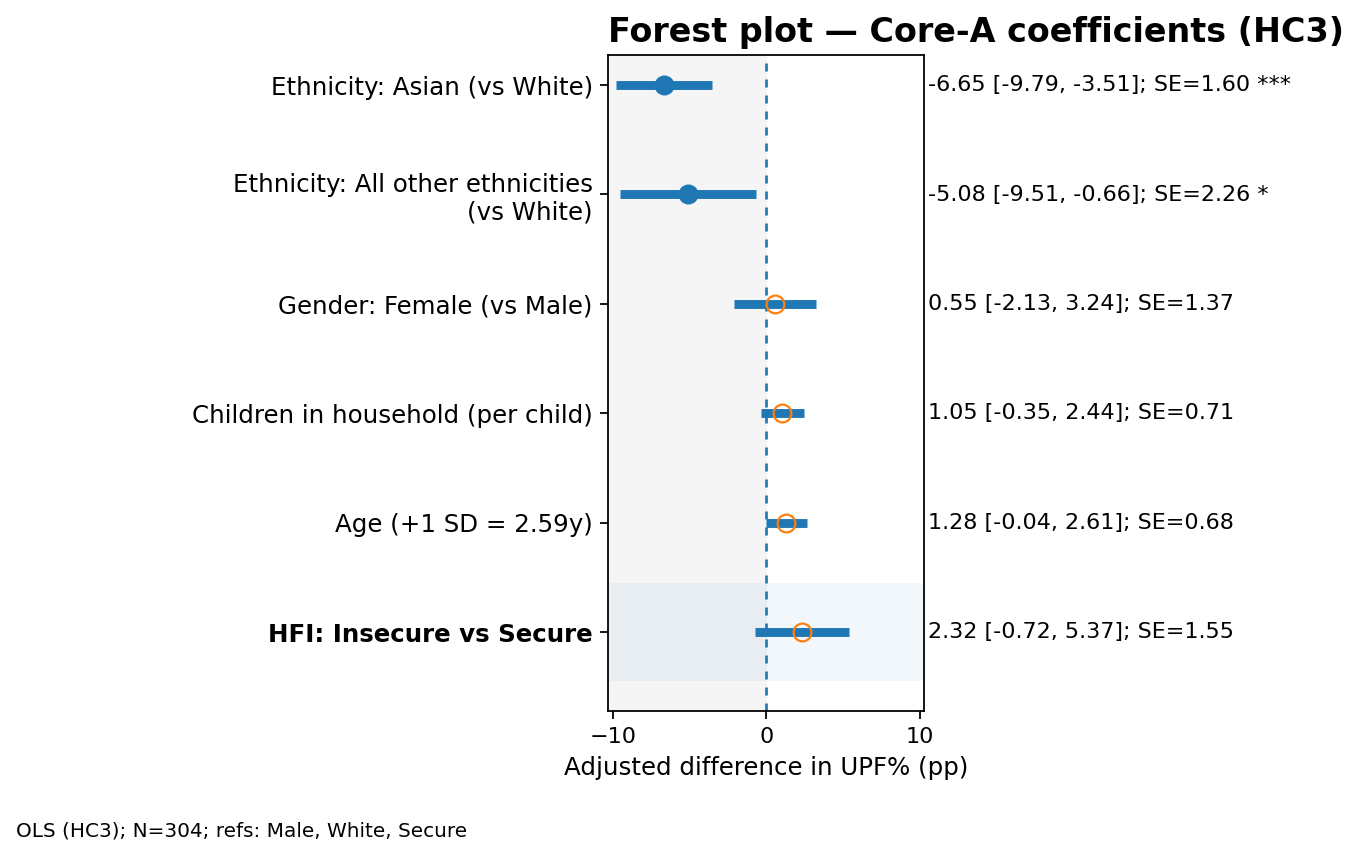

Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/forest_coreA.png


In [12]:
# =========================================================
# ============ 美化版 Forest Plot — Core-A (HC3) ==========
# =========================================================
import re, textwrap
import numpy as np
import matplotlib.pyplot as plt

show_age_per_sd = True      # 若想显示“每 +1SD”，置 True；否则按每年
gender_map = {1:"Male", 2:"Female", 3:"Other"}  # 你给定的性别口径

# 取系数/区间/显著性
try:
    z = _zcrit(0.05)
except NameError:
    z = 1.95996398454

names  = list(res_coreA.model.exog_names)
params = pd.Series(np.asarray(res_coreA.params).ravel(),  index=names)
bse    = pd.Series(np.asarray(res_coreA.bse).ravel(),     index=names)
pvals  = pd.Series(np.asarray(res_coreA.pvalues).ravel(), index=names)

# ==== 修改①：构建 df 时加入 se 列（后面要缩放） ====
df = pd.DataFrame({
    "term": names,
    "b":   params.values,
    "se":  bse.values,                                # <-- 新增
    "lo":  (params - z*bse).values,
    "hi":  (params + z*bse).values,
    "p":   pvals.values
})

# 仅保留关心的项
keep = (
    (df.term=="HFI_binary") |
    (df.term=="age_participant") |
    (df.term=="child_numbers") |
    (df.term.str.startswith("C(gender_participant")) |
    (df.term.str.startswith("C(ethn_participant"))
)
df = df.loc[keep].copy()

# ==== 修改②：年龄换算为 +1SD（连同 se 一起缩放） ====
if show_age_per_sd and "age_participant" in df.term.values:
    sd_age = float(dat_coreA["age_participant"].astype(float).std())
    idx = df.term=="age_participant"
    df.loc[idx, ["b","lo","hi","se"]] = (
        df.loc[idx, ["b","lo","hi","se"]].to_numpy() * sd_age
    )
    age_label = f"Age (+1 SD = {sd_age:.2f}y)"
else:
    age_label = "Age (per year)"

# ---------- 2) 生成可读标签 ----------
def label(term: str) -> str:
    if term=="HFI_binary": return "HFI: Insecure vs Secure"
    if term=="age_participant": return age_label
    if term=="child_numbers": return "Children in household (per child)"
    mg = re.match(r"C\(gender_participant.*\)\[T\.(.+)\]", term)
    if mg:
        code = mg.group(1)
        name = gender_map.get(code, gender_map.get(int(code), code))
        return f"Gender: {name} (vs Male)"
    me = re.match(r"C\(ethn_participant.*\)\[T\.(.+)\]", term)
    if me:
        v = me.group(1).strip()
        return f"Ethnicity: {v} (vs White)"
    return term

df["label"] = df["term"].apply(label)
df["label_wrapped"] = df["label"].apply(lambda s: textwrap.fill(s, width=34))

# 排序：HFI → Age → Children → Gender → Ethnicity
order = ["HFI_binary","age_participant","child_numbers"]
order += sorted(df.loc[df.term.str.startswith("C(gender_participant"),"term"])
order += sorted(df.loc[df.term.str.startswith("C(ethn_participant"),"term"])
df = df.set_index("term").loc[order].reset_index()

# ---------- 3) 绘图（粗横条 + 显著=实心/不显著=空心） ----------
labels = df["label_wrapped"].tolist()
# 取数组
b, lo, hi, p = map(np.asarray, [df["b"], df["lo"], df["hi"], df["p"]])
se = np.asarray(df["se"])   # ← 新增：用于显示 SE（已随 +1SD 同步缩放）

# ==== 修改③：统一用 ypos，不再用 y ====
ypos = np.arange(len(labels))
sig = p < 0.05

fig_h = 3.6 + 0.35*len(labels)
fig, ax = plt.subplots(figsize=(9.5, fig_h), dpi=160)

# 自适应范围 + 0线/负区背景
pad = 1.05 * max(abs(np.nanmin(lo)), abs(np.nanmax(hi)))
ax.set_xlim(-pad, pad)
ax.axvline(0, ls=(0,(3,3)), lw=1.2, zorder=1)
ax.axvspan(-pad, 0, color="0.96", zorder=0)

# 95%CI 粗横条 + 点（显著实心/不显著空心）
for yi, (loi, hii) in enumerate(zip(lo, hi)):
    ax.hlines(yi, xmin=loi, xmax=hii, lw=4.0, zorder=2)
ax.plot(b[sig],  ypos[sig],  "o", ms=8, zorder=3)
ax.plot(b[~sig], ypos[~sig], "o", ms=8, mfc="none", zorder=3)

# 轴与标签
ax.set_yticks(ypos); ax.set_yticklabels(labels, fontsize=11)
ax.set_xlabel("Adjusted difference in UPF% (pp)", fontsize=11)

# 右侧标注“点估计 [CI]”
def stars(pv): return "***" if pv<1e-3 else "**" if pv<1e-2 else "*" if pv<0.05 else ""
for yi, (bi, loi, hii, pi, sei) in enumerate(zip(b, lo, hi, p, se)):   # ← 加 se
    ax.text(1.01, yi, f"{bi:.2f} [{loi:.2f}, {hii:.2f}]; SE={sei:.2f} {stars(pi)}",
            transform=ax.get_yaxis_transform(), ha="left", va="center", fontsize=10)

# 高亮 HFI 行
if "HFI_binary" in df["term"].values:
    hfi_idx = int(np.where(df["term"].values=="HFI_binary")[0])
    ax.axhspan(hfi_idx-0.45, hfi_idx+0.45, alpha=0.06, zorder=0)
    ax.get_yticklabels()[hfi_idx].set_fontweight("bold")

ax.set_title("Forest plot — Core-A coefficients (HC3)", loc="left", fontsize=15, weight="bold", pad=6)
fig.text(0.12, 0.02, f"OLS (HC3); N={len(dat_coreA)}; refs: Male, White, Secure",
         ha="left", va="bottom", fontsize=9)

plt.tight_layout(rect=[0.22, 0.06, 0.98, 0.95])

# 保存/显示
out = "/content/drive/MyDrive/UPF-HFI/outcome_figure/forest_coreA.png"   # 可改路径
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show(); plt.close(fig)
print("Saved:", out)


# 3. Core-B 交互（HFI × 族裔三类；参考White）

In [13]:
# ===== 3. Core-B 交互（HFI × 族裔三类；参考 White）— 稳健版 =====
need_cols_B = [OUTCOME, "HFI_binary", "age_participant",
               "gender_participant", "ethn_participant", "child_numbers"]

dat_coreB = df_model[need_cols_B].copy()
for col in ["age_participant", "child_numbers", "HFI_binary"]:
    dat_coreB[col] = pd.to_numeric(dat_coreB[col], errors="coerce")
dat_coreB = dat_coreB.dropna().copy()

print(f"Core-B 样本量: {len(dat_coreB)}")

form_coreB = (
    f"{OUTCOME} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
    " + HFI_binary:C(ethn_participant, Treatment(reference='White'))"
)
res_coreB = fit_ols(form_coreB, dat_coreB, cov_type="HC3")

groups = ["White", "Asian", "All other ethnicities"]

def _find_inter_name(result, group_label: str):
    """在模型里找到对应族裔的交互项名；若不存在返回 None。"""
    names = list(getattr(result.model, "exog_names", []))
    suf = f"[T.{group_label}]"
    for nm in names:
        if nm.startswith("HFI_binary:C(ethn_participant") and nm.endswith(suf):
            return nm
    return None

rows = []
for g in groups:
    combo = {"HFI_binary": 1.0}
    if g != "White":
        key = _find_inter_name(res_coreB, g)
        if key is None:
            print(f"[警告] 未找到 {g} 的交互项，可能该水平在样本中缺失。")
        else:
            combo[key] = 1.0
    est, ci, p = linear_combo(res_coreB, combo)
    lo, hi = ci
    rows.append({"group": g, "d": est, "lo": lo, "hi": hi, "p": p})

effects_df = pd.DataFrame(rows)
p_inter = joint_test_interaction(res_coreB, "HFI_binary:C(ethn_participant, Treatment(reference='White'))")

# 漂亮地打印
print("\nEthnicity-specific ΔUPF (insecure − secure):")
for r in effects_df.itertuples():
    sig = "*" if r.p < 0.05 else ""
    print(f"  {r.group:>22}: {r.d:+.2f} pp [{r.lo:.2f}, {r.hi:.2f}]  p={r.p:.3f}{sig}")
print(f"\nOverall interaction test: p-interaction = {p_inter:.3f}")

# 组内 n 与导出
n_by_grp = dat_coreB.groupby("ethn_participant")["HFI_binary"].size()
effects_df["n"] = effects_df["group"].map(n_by_grp.to_dict())
effects_df.to_csv("/content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_effects.csv", index=False)
print("Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_effects.csv")


Core-B 样本量: 304

Ethnicity-specific ΔUPF (insecure − secure):
                   White: +0.99 pp [-3.23, 5.22]  p=0.644
                   Asian: +2.16 pp [-2.92, 7.25]  p=0.404
   All other ethnicities: +7.48 pp [-0.94, 15.90]  p=0.082

Overall interaction test: p-interaction = 0.405
Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_effects.csv


/tmp/ipython-input-767345847.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_by_grp = dat_coreB.groupby("ethn_participant")["HFI_binary"].size()


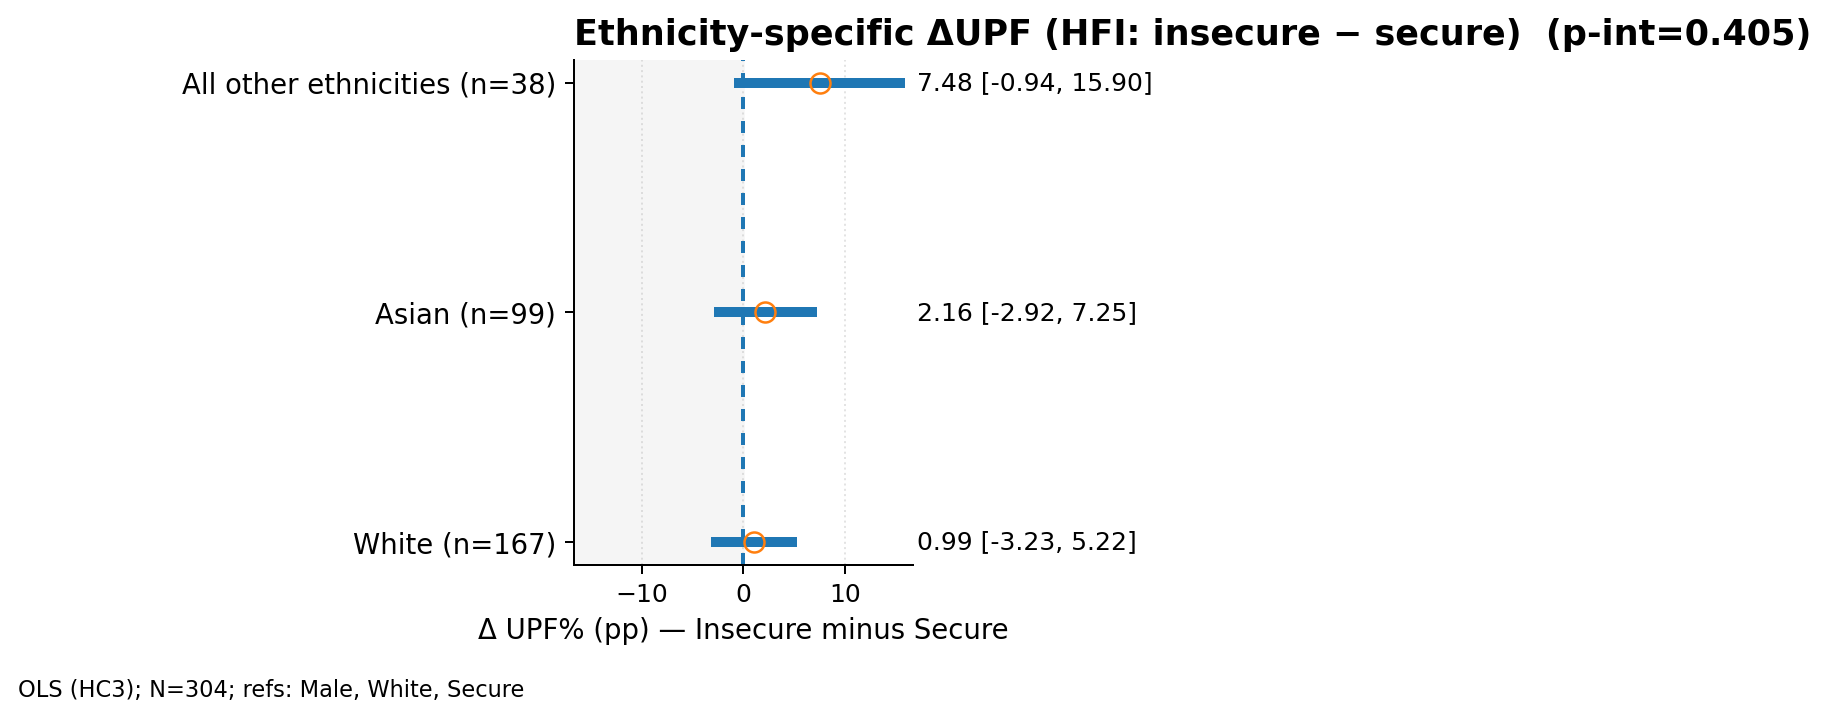

Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_dUPF.png


In [14]:
# === Figure: ΔUPF by Ethnicity (HFI insecure − secure), with 95% CI ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 若上一块已生成 effects_df，这里直接复用；否则请先运行上一块
df_eff = effects_df.copy()

# 固定顺序 & 标签加 n
order = ["White", "Asian", "All other ethnicities"]
df_eff["n"] = df_eff["n"].fillna(0).astype(int)
df_eff["label"] = df_eff.apply(lambda r: f"{r['group']} (n={r['n']})", axis=1)
df_eff = df_eff.set_index("group").loc[order].reset_index()

# 画图：粗横条 + 实心/空心点；对称坐标 + 加粗零线
ypos = np.arange(len(df_eff))
sig  = df_eff["p"].values < 0.05

fig_h = 3.2 + 0.35 * len(df_eff)
fig, ax = plt.subplots(figsize=(7.6, fig_h), dpi=180)

# 95% CI 横条
for i, (lo, hi) in enumerate(zip(df_eff["lo"], df_eff["hi"])):
    ax.hlines(ypos[i], xmin=lo, xmax=hi, lw=4.0, zorder=2)

# 点：显著=实心，不显著=空心
ax.plot(df_eff["d"].values[sig],  ypos[sig],  "o", ms=8, zorder=3)
ax.plot(df_eff["d"].values[~sig], ypos[~sig], "o", ms=8, mfc="none", zorder=3)

# 轴 & 0 线 & 对称范围
mx = 1.05 * max(abs(df_eff["lo"].min()), abs(df_eff["hi"].max()))
ax.set_xlim(-mx, mx)
ax.axvspan(-mx, 0, color="0.96", zorder=0)
ax.axvline(0, ls=(0,(3,3)), lw=1.6)

ax.set_yticks(ypos); ax.set_yticklabels(df_eff["label"], fontsize=11)
ax.set_xlabel("Δ UPF% (pp) — Insecure minus Secure", fontsize=11)

# 右侧数值+星号
def stars(pv): return "***" if pv<1e-3 else "**" if pv<1e-2 else "*" if pv<0.05 else ""
for yi, r in enumerate(df_eff.itertuples()):
    ax.text(1.01, yi, f"{r.d:.2f} [{r.lo:.2f}, {r.hi:.2f}] {stars(r.p)}",
            transform=ax.get_yaxis_transform(), ha="left", va="center", fontsize=10)

# 标题含 p-interaction；图注含 N 与参考组
title = f"Ethnicity-specific ΔUPF (HFI: insecure − secure)  (p-int={p_inter:.3f})"
ax.set_title(title, loc="left", fontsize=14, weight="bold", pad=6)
fig.text(0.12, 0.02, f"OLS (HC3); N={len(dat_coreB)}; refs: Male, White, Secure", ha="left", va="bottom", fontsize=9)

# 美化与保存
ax.grid(axis='x', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout(rect=[0.22, 0.06, 0.98, 0.95])

Path("output").mkdir(exist_ok=True)
plt.savefig("/content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_dUPF.png", dpi=300, bbox_inches="tight")
plt.show(); plt.close(fig)
print("Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_dUPF.png")

# 4. Robustness（结构性混杂）：一次性加入 SES（income, employ）

In [15]:
# ===== Robustness: add SES once (same-N), print only =====
import numpy as np, pandas as pd

# 同一样本（用于 Core-A 与 +SES 两个模型的严格对比）
ses_cols = [OUTCOME, "HFI_binary", "age_participant",
            "gender_participant", "ethn_participant", "child_numbers",
            "income", "employ"]
dat_R = df_model[ses_cols].copy()
for col in ["HFI_binary","age_participant","child_numbers","income"]:
    dat_R[col] = pd.to_numeric(dat_R[col], errors="coerce")
dat_R = dat_R.dropna().copy()

print(f"\nRobustness(+SES) 样本量（same-N）: {len(dat_R)}")

# 两个模型都基于同一个 dat_R
res_coreA_sameN = fit_ols(
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers",
    dat_R, cov_type="HC3"
)
res_ses = fit_ols(
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers + income + C(employ)",
    dat_R, cov_type="HC3"
)

# 取系数与区间
b_core, ci_core, p_core = coef_ci(res_coreA_sameN, "HFI_binary")
b_ses , ci_ses , p_ses  = coef_ci(res_ses,          "HFI_binary")

# 增减比例（b_core 的相对变化）
atten = np.nan
if pd.notna(b_core) and not np.isclose(b_core, 0.0):
    atten = 100.0 * (b_core - b_ses) / abs(b_core)
chg = "attenuation" if atten >= 0 else "increase"

print(f"HFI: Core-A = {b_core:.2f} pp [ {ci_core[0]:.2f}, {ci_core[1]:.2f} ] (p={p_core:.3f})")
print(f"     +SES    = {b_ses:.2f} pp [ {ci_ses[0]:.2f}, {ci_ses[1]:.2f} ] (p={p_ses:.3f})")
print(f"Δ = {b_ses-b_core:+.2f} pp  ({chg} {abs(atten):.1f}%)  — Same sample N={len(dat_R)}; OLS(HC3)")

# 可选：报告 HFI 的 partial R²（若你已引入 partial_R2 工具函数）
try:
    r2_core, pF_core = partial_R2(res_coreA_sameN, "HFI_binary")
    r2_ses , pF_ses  = partial_R2(res_ses,          "HFI_binary")
    print(f"partial R²(HFI): Core-A {r2_core:.3f} (p={pF_core:.3f}) → +SES {r2_ses:.3f} (p={pF_ses:.3f})")
except Exception:
    pass

# 若想导出到表格：
out_tab = pd.DataFrame({
    "model":["Core-A","Core-A + SES"],
    "beta":[b_core, b_ses],
    "ci_lo":[ci_core[0], ci_ses[0]],
    "ci_hi":[ci_core[1], ci_ses[1]],
    "p":[p_core, p_ses],
    "N":len(dat_R)
})
out_tab.to_csv("output/robustness_ses_sameN.csv", index=False)
print("Saved: output/robustness_ses_sameN.csv")



Robustness(+SES) 样本量（same-N）: 299
HFI: Core-A = 2.75 pp [ -0.30, 5.80 ] (p=0.078)
     +SES    = 3.34 pp [ 0.04, 6.64 ] (p=0.048)
Δ = +0.59 pp  (increase 21.3%)  — Same sample N=299; OLS(HC3)
Saved: output/robustness_ses_sameN.csv


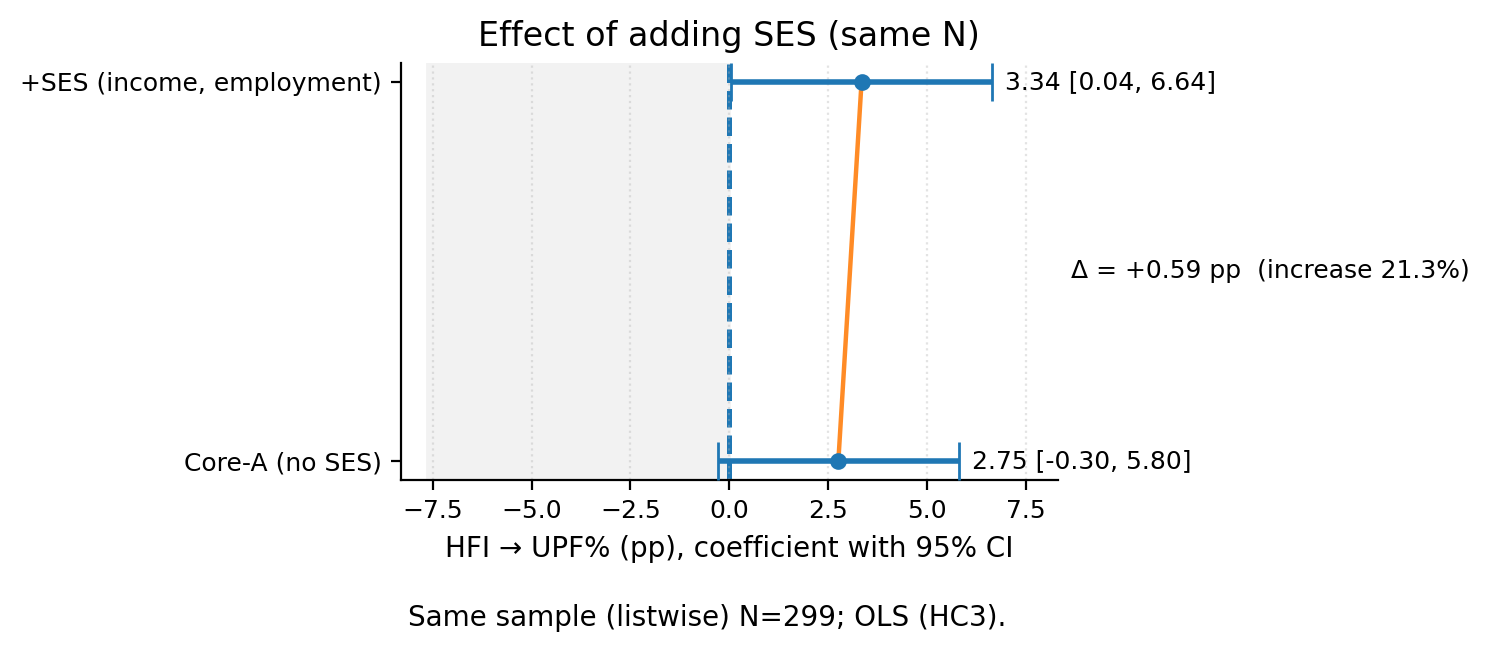

In [16]:
# ===== Figure 4. Effect of adding SES (same N) =====
import numpy as np, matplotlib.pyplot as plt

labels = ["Core-A (no SES)", "+SES (income, employment)"]
b  = np.array([b_core, b_ses], dtype=float)
lo = np.array([ci_core[0], ci_ses[0]], dtype=float)
hi = np.array([ci_core[1], ci_ses[1]], dtype=float)
err = np.vstack([b - lo, hi - b])

plt.rcParams.update({
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
})

fig, ax = plt.subplots(figsize=(7.6, 3.6), dpi=200)
ypos = np.arange(2)

# 横轴范围 & 底色
mx = float(np.max(np.abs(np.r_[lo, hi])))
ax.set_xlim(-1.25*mx, 1.25*mx)
ax.axvspan(-1.15*mx, 0, color="0.95", zorder=0)   # 负区浅底
ax.axvline(0, linestyle='--', linewidth=1.8, zorder=1)

# 误差线 + 点 + 连接线
ax.errorbar(b, ypos, xerr=err, fmt='o', capsize=7, elinewidth=2, markersize=5, zorder=3)
ax.plot(b, ypos, linewidth=1.6, alpha=0.9, zorder=2)

# 轴标签
ax.set_yticks(ypos, labels)
ax.set_xlabel("HFI → UPF% (pp), coefficient with 95% CI")
ax.set_title("Effect of adding SES (same N)")

# 右侧文字（Δ 与增减比例）
delta = b[1] - b[0]
chg = "attenuation" if atten >= 0 else "increase"
ax.text(ax.get_xlim()[1] + 0.02*(ax.get_xlim()[1]-ax.get_xlim()[0]),
        0.5, f"Δ = {delta:+.2f} pp  ({chg} {abs(atten):.1f}%)",
        va='center', ha='left', fontsize=9, transform=ax.transData)

# 在点旁直接标注“估计 [CI]”
shift = 0.03 * (ax.get_xlim()[1]-ax.get_xlim()[0])
# —— 把标签放在置信区间外侧（右侧或左侧），避免遮住误差线 ——
span = ax.get_xlim()[1] - ax.get_xlim()[0]
pad  = 0.02 * span  # 外侧偏移

for i in range(2):
    label = f"{b[i]:.2f} [{lo[i]:.2f}, {hi[i]:.2f}]"
    if b[i] >= 0:
        # 点在右半区：把标签放到上界 hi 的右侧
        anchor_x = hi[i]
        text_x   = hi[i] + pad
        ha       = 'left'
    else:
        # 点在左半区：把标签放到下界 lo 的左侧
        anchor_x = lo[i]
        text_x   = lo[i] - pad
        ha       = 'right'

    ax.annotate(label, xy=(anchor_x, ypos[i]), xytext=(text_x, ypos[i]),
                va='center', ha=ha, fontsize=9)

ax.grid(axis='x', linestyle=':', alpha=0.35)
ax.text(0.01, -0.35, f"Same sample (listwise) N={len(dat_R)}; OLS (HC3).", transform=ax.transAxes)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()

# 若需要保存：
import pathlib; pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/figure2_ses_sameN.png", dpi=300, bbox_inches="tight")

plt.show()


## 对比

In [17]:
# ===== Robustness: add SES once — fresh-N (each model uses its own available rows) =====
import numpy as np, pandas as pd

# 1) 各自样本
coreA_cols_fresh = [OUTCOME, "HFI_binary", "age_participant",
                    "gender_participant", "ethn_participant", "child_numbers"]
ses_cols_fresh   = coreA_cols_fresh + ["income", "employ"]

dat_coreA_fresh = df_model[coreA_cols_fresh].copy()
for c in ["HFI_binary","age_participant","child_numbers"]:
    dat_coreA_fresh[c] = pd.to_numeric(dat_coreA_fresh[c], errors="coerce")
dat_coreA_fresh = dat_coreA_fresh.dropna().copy()

dat_ses_fresh = df_model[ses_cols_fresh].copy()
for c in ["HFI_binary","age_participant","child_numbers","income"]:
    dat_ses_fresh[c] = pd.to_numeric(dat_ses_fresh[c], errors="coerce")
dat_ses_fresh = dat_ses_fresh.dropna().copy()

print(f"Core-A fresh-N: N={len(dat_coreA_fresh)}")
print(f"+SES  fresh-N: N={len(dat_ses_fresh)}")

# 2) 拟合两个模型（各自 fresh-N）
form_core = (
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
form_ses  = form_core + " + income + C(employ)"

res_core_fresh = fit_ols(form_core, dat_coreA_fresh, cov_type="HC3")
res_ses_fresh  = fit_ols(form_ses,  dat_ses_fresh,  cov_type="HC3")

# 3) 系数与区间
b_core_f, ci_core_f, p_core_f = coef_ci(res_core_fresh, "HFI_binary")
b_ses_f , ci_ses_f , p_ses_f  = coef_ci(res_ses_fresh,  "HFI_binary")

# 4) 变化幅度（fresh-N）
atten_f = np.nan
if pd.notna(b_core_f) and not np.isclose(b_core_f, 0.0):
    atten_f = 100.0 * (b_core_f - b_ses_f) / abs(b_core_f)
chg_f = "attenuation" if atten_f >= 0 else "increase"

print(f"HFI (fresh-N):")
print(f"  Core-A = {b_core_f:.2f} pp [{ci_core_f[0]:.2f}, {ci_core_f[1]:.2f}]  (p={p_core_f:.3f})")
print(f"  +SES   = {b_ses_f:.2f} pp [{ci_ses_f[0]:.2f}, {ci_ses_f[1]:.2f}]  (p={p_ses_f:.3f})")
print(f"  Δ = {b_ses_f-b_core_f:+.2f} pp  ({chg_f} {abs(atten_f):.1f}%)")

# 5) 与 same-N 的对比（如果前面变量在环境中）
try:
    _ = b_core  # same-N 变量是否存在
    print("\nCompare to same-N:")
    print(f"  Core-A: fresh − same = {b_core_f - b_core:+.2f} pp")
    print(f"  +SES  : fresh − same = {b_ses_f  - b_ses:+.2f} pp")
    print(f"  Δ(change due to SES): fresh − same = {(b_ses_f-b_core_f) - (b_ses-b_core):+.2f} pp")
except NameError:
    pass

# 可选：导出一张对比小表
out_tab_fresh = pd.DataFrame({
    "model":["Core-A (fresh)","+SES (fresh)"],
    "beta":[b_core_f, b_ses_f],
    "ci_lo":[ci_core_f[0], ci_ses_f[0]],
    "ci_hi":[ci_core_f[1], ci_ses_f[1]],
    "p":[p_core_f, p_ses_f],
    "N":[len(dat_coreA_fresh), len(dat_ses_fresh)]
})
out_tab_fresh.to_csv("output/robustness_ses_freshN.csv", index=False)
print("Saved: output/robustness_ses_freshN.csv")


Core-A fresh-N: N=304
+SES  fresh-N: N=299
HFI (fresh-N):
  Core-A = 2.32 pp [-0.72, 5.37]  (p=0.136)
  +SES   = 3.34 pp [0.04, 6.64]  (p=0.048)
  Δ = +1.02 pp  (increase 43.8%)

Compare to same-N:
  Core-A: fresh − same = -0.43 pp
  +SES  : fresh − same = +0.00 pp
  Δ(change due to SES): fresh − same = +0.43 pp
Saved: output/robustness_ses_freshN.csv


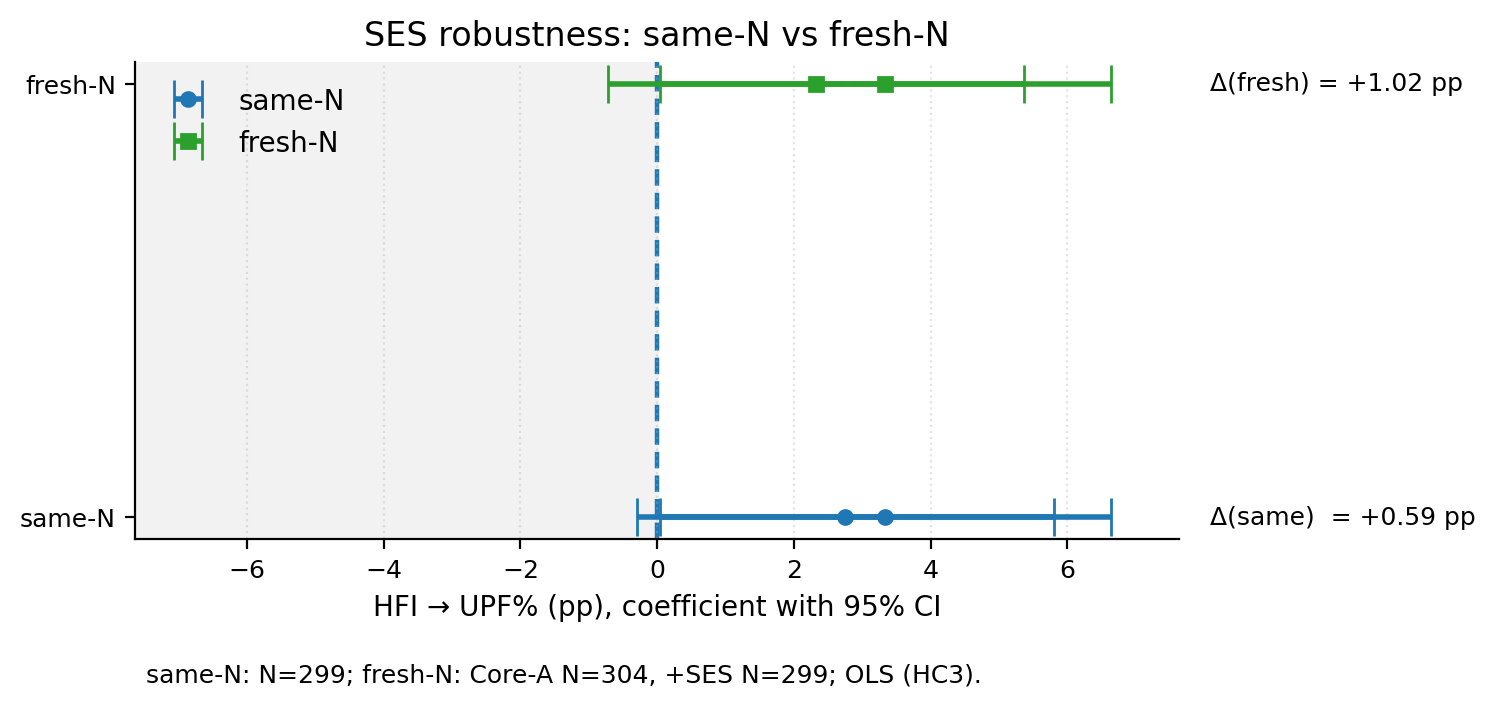

In [18]:
# ===== Figure 5. +SES effect — same-N vs fresh-N (overlay dumbbells) =====
import numpy as np, matplotlib.pyplot as plt

# 需要：同一内核里已有 same-N 的 b_core, ci_core, b_ses, ci_ses, len(dat_R)
# 以及 fresh-N 的 b_core_f, ci_core_f, b_ses_f, ci_ses_f, len(dat_coreA_fresh), len(dat_ses_fresh)

# 统一横轴范围覆盖两套区间
all_bounds = np.array([ci_core[0], ci_core[1], ci_ses[0], ci_ses[1],
                       ci_core_f[0], ci_core_f[1], ci_ses_f[0], ci_ses_f[1]], float)
mx = float(np.max(np.abs(all_bounds))) * 1.15

fig, ax = plt.subplots(figsize=(7.6, 3.8), dpi=200)
ax.set_xlim(-mx, mx)
ax.axvspan(-mx, 0, color="0.95", zorder=0)
ax.axvline(0, ls='--', lw=1.6, zorder=1)

# y 位置：0 = same-N, 1 = fresh-N
ypos = np.array([0,1])

# same-N
b_same  = np.array([b_core,  b_ses ], float)
lo_same = np.array([ci_core[0], ci_ses[0]], float)
hi_same = np.array([ci_core[1], ci_ses[1]], float)
ax.errorbar(
    b_same,
    np.full(b_same.shape, ypos[0]),                   # ← 原来是 ypos[0]
    xerr=np.vstack([b_same-lo_same, hi_same-b_same]),
    fmt='o', capsize=7, elinewidth=2, markersize=5, label="same-N", zorder=3
)
ax.plot(b_same,  [ypos[0], ypos[0]], lw=1.6, alpha=0.9, zorder=2)

# fresh-N（不同点形+虚线连接）
b_fresh  = np.array([b_core_f, b_ses_f], float)
lo_fresh = np.array([ci_core_f[0], ci_ses_f[0]], float)
hi_fresh = np.array([ci_core_f[1], ci_ses_f[1]], float)
ax.errorbar(
    b_fresh,
    np.full(b_fresh.shape, ypos[1]),                  # ← 原来是 ypos[1]
    xerr=np.vstack([b_fresh-lo_fresh, hi_fresh-b_fresh]),
    fmt='s', capsize=7, elinewidth=2, markersize=5, label="fresh-N", zorder=3
)
ax.plot(b_fresh, [ypos[1], ypos[1]], lw=1.6, alpha=0.9, linestyle=':', zorder=2)

# 轴与标签
ax.set_yticks(ypos, ["same-N", "fresh-N"])
ax.set_xlabel("HFI → UPF% (pp), coefficient with 95% CI")
ax.set_title("SES robustness: same-N vs fresh-N")

# 右侧写 Δ
shift = 0.03 * (ax.get_xlim()[1]-ax.get_xlim()[0])
ax.text(ax.get_xlim()[1] + shift, ypos[0], f"Δ(same)  = {b_same[1]-b_same[0]:+.2f} pp", va='center', ha='left', fontsize=9)
ax.text(ax.get_xlim()[1] + shift, ypos[1], f"Δ(fresh) = {b_fresh[1]-b_fresh[0]:+.2f} pp", va='center', ha='left', fontsize=9)

# 图注：两套样本量
ax.text(0.01, -0.30,
        f"same-N: N={len(dat_R)}; fresh-N: Core-A N={len(dat_coreA_fresh)}, +SES N={len(dat_ses_fresh)}; OLS (HC3).",
        transform=ax.transAxes, fontsize=9)

ax.legend(frameon=False, loc="upper left")
ax.grid(axis='x', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()

# 保存（可选）
import pathlib; pathlib.Path('output').mkdir(exist_ok=True)
plt.savefig('output/figureSx_ses_same_vs_fresh.png', dpi=300, bbox_inches='tight')

plt.show()


In [19]:
# 1) 直接列出“缺 SES”的那几行的关键信息（case-centric）
miss = df_model[[OUTCOME,"HFI_binary","ethn_participant","gender_participant",
                 "age_participant","child_numbers","income","employ"]].copy()
miss = miss[miss["income"].isna() | miss["employ"].isna()]
print(len(miss))              # 应该是 5
print(miss[["HFI_binary","ethn_participant"]].value_counts())  # 谁占的多


5
HFI_binary  ethn_participant     
0.0         White                    3
1.0         Asian                    1
            All other ethnicities    1
Name: count, dtype: int64


# 5. Sensitivity（关键假设变化）

## 5.1 HFI 三分类(有序) + 趋势检验

In [20]:
# ===== Sensitivity: HFI 3-category + trend (print only) =====
import numpy as np, pandas as pd
from pandas.api.types import CategoricalDtype

if "HFI_category" in df_model.columns:
    # 统一类型与顺序
    ord_dtype = CategoricalDtype(
        categories=["Food secure","Low food security","Very low food security"], ordered=True
    )
    df_model["HFI_category"] = df_model["HFI_category"].astype(ord_dtype)

    # 同一套自变量 + 三分类列
    sens_cols = [OUTCOME, "HFI_binary", "age_participant",
                 "gender_participant", "ethn_participant", "child_numbers",
                 "HFI_category"]
    dat_sens = df_model[sens_cols].copy()
    # 强转为数值，防止混入字符串
    for col in ["HFI_binary","age_participant","child_numbers"]:
        dat_sens[col] = pd.to_numeric(dat_sens[col], errors="coerce")
    dat_sens = dat_sens.dropna().copy()

    print(f"\nSensitivity—有序三分类 样本量: {len(dat_sens)}")

    # (a) 类别模型（相对 Food secure）
    form_cat = (
        f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
        " + age_participant"
        " + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_cat = fit_ols(form_cat, dat_sens, cov_type="HC3")

    print("\nAdjusted difference vs Food secure:")
    for lev in ["Low food security","Very low food security"]:
        term = f"C(HFI_category, Treatment(reference='Food secure'))[T.{lev}]"
        est, ci, p = coef_ci(res_cat, term)
        print(f"  {lev:>21}: {est:+.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}); p={p:.3f}")

    # (b) 趋势检验（0/1/2 连续）
    tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
    dat_sens["HFI_trend"] = dat_sens["HFI_category"].map(tr_map).astype(float)

    form_trend = (
        f"{OUTCOME} ~ HFI_trend"
        " + age_participant"
        " + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_trend = fit_ols(form_trend, dat_sens, cov_type="HC3")
    est, ci, p = coef_ci(res_trend, "HFI_trend")
    print(f"\np-trend: 每升一档 HFI，UPF% 变化 {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}); p={p:.3f}")

else:
    print("\n[跳过] 未找到 HFI_category（三分类）列，已跳过敏感性-三分类与趋势检验。")



Sensitivity—有序三分类 样本量: 304

Adjusted difference vs Food secure:
      Low food security: +0.87 pp (95%CI -3.11, 4.85); p=0.668
  Very low food security: +3.80 pp (95%CI -0.06, 7.65); p=0.055

p-trend: 每升一档 HFI，UPF% 变化 1.75 pp (95%CI -0.11, 3.60); p=0.066


In [21]:
# —— 共享：拟合类别模型 & 趋势模型，并做边际预测 ——
import numpy as np, pandas as pd
from pandas.api.types import CategoricalDtype

cats = ["Food secure","Low food security","Very low food security"]
df_model["HFI_category"] = df_model["HFI_category"].astype(
    CategoricalDtype(categories=cats, ordered=True)
)

sens_cols = [OUTCOME, "age_participant","gender_participant",
             "ethn_participant","child_numbers","HFI_category"]
dat = df_model[sens_cols].copy()
for c in ["age_participant","child_numbers"]:
    dat[c] = pd.to_numeric(dat[c], errors="coerce")
dat = dat.dropna().copy()

# 类别模型（相对 Food secure），与正文一致
form_cat = (
    f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers"
)
res_cat = fit_ols(form_cat, dat, cov_type="HC3")

# 典型协变量下的预测均值（每类一条）
grid = pd.DataFrame({
    "HFI_category": cats,
    "age_participant": dat["age_participant"].mean(),
    "gender_participant": 1,      # Male
    "ethn_participant": "White",
    "child_numbers": dat["child_numbers"].mean(),
})
sf    = res_cat.get_prediction(grid).summary_frame(alpha=0.05)
means = sf["mean"].to_numpy(float)
lo    = sf["mean_ci_lower"].to_numpy(float)
hi    = sf["mean_ci_upper"].to_numpy(float)
yerr  = np.vstack([means - lo, hi - means])
n_by  = dat["HFI_category"].value_counts().reindex(cats, fill_value=0).astype(int)

# 趋势（0/1/2）
dat["HFI_trend"] = dat["HFI_category"].map({"Food secure":0, "Low food security":1, "Very low food security":2}).astype(float)
res_trend = fit_ols(
    f"{OUTCOME} ~ HFI_trend + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers",
    dat, cov_type="HC3"
)
slope, (slo, shi), p_trend = coef_ci(res_trend, "HFI_trend")


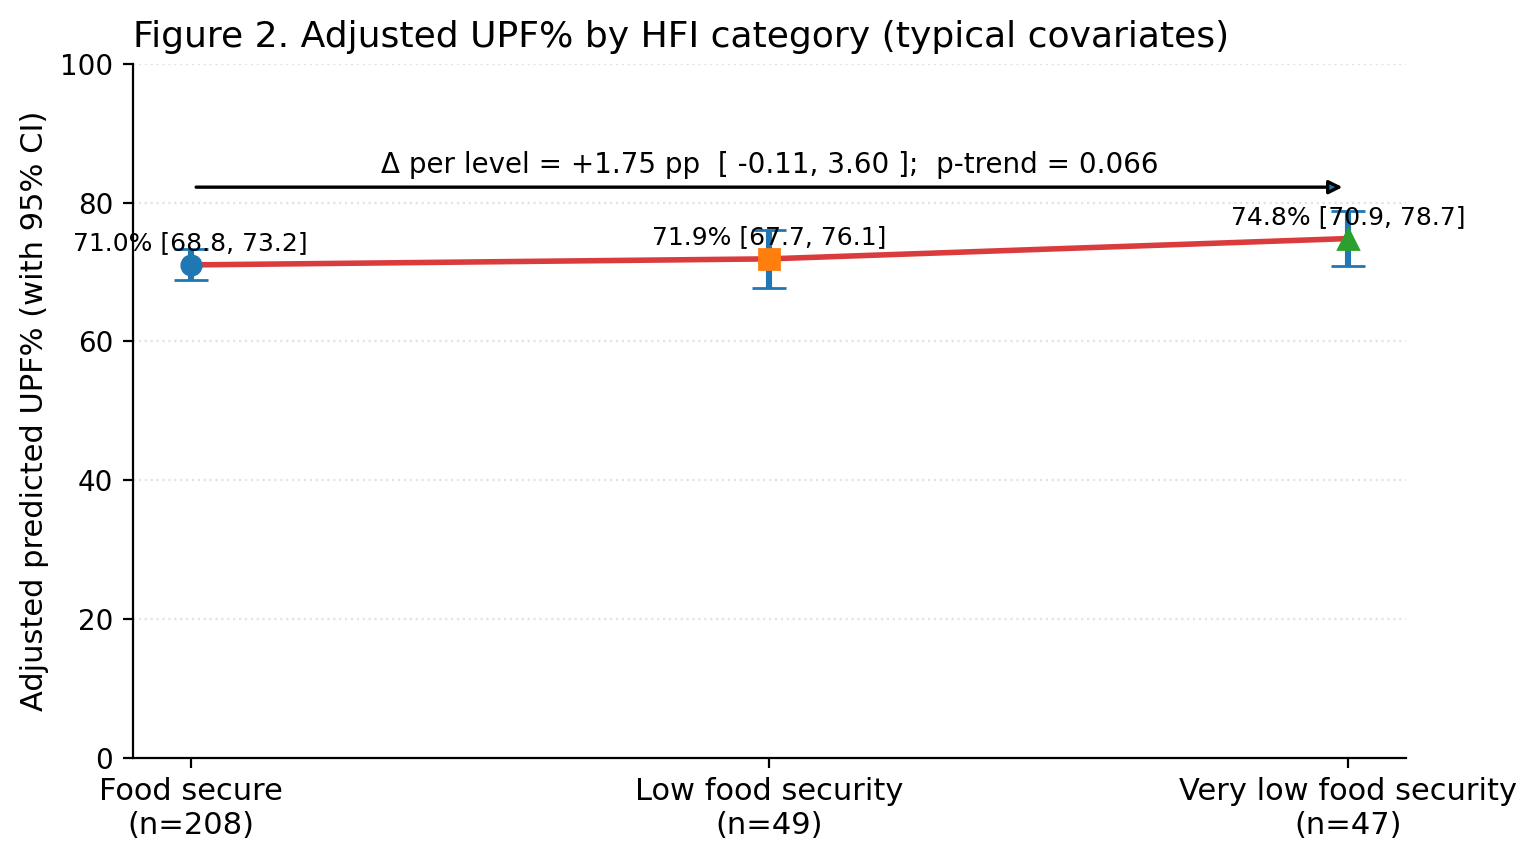

In [22]:
# === Figure 2 (polished): Adjusted UPF% by HFI category + trend arrow ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# 1) 数据与模型（与主文一致）
cats = ["Food secure","Low food security","Very low food security"]
df_model["HFI_category"] = df_model["HFI_category"].astype(
    CategoricalDtype(categories=cats, ordered=True)
)

sens_cols = [OUTCOME, "age_participant","gender_participant",
             "ethn_participant","child_numbers","HFI_category"]
dat_sens = df_model[sens_cols].copy()
for col in ["age_participant","child_numbers"]:
    dat_sens[col] = pd.to_numeric(dat_sens[col], errors="coerce")
dat_sens = dat_sens.dropna().copy()

form_cat = (
    f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers"
)
res_cat = fit_ols(form_cat, dat_sens, cov_type="HC3")

# 2) 典型协变量预测
grid = pd.DataFrame({
    "HFI_category": cats,
    "age_participant": dat_sens["age_participant"].mean(),
    "gender_participant": 1,
    "ethn_participant": "White",
    "child_numbers": dat_sens["child_numbers"].mean(),
})
pred  = res_cat.get_prediction(grid).summary_frame(alpha=0.05)
means = pred["mean"].to_numpy(float)
lo    = pred["mean_ci_lower"].to_numpy(float)
hi    = pred["mean_ci_upper"].to_numpy(float)
yerr  = np.vstack([means - lo, hi - means])
n_by  = dat_sens["HFI_category"].value_counts().reindex(cats, fill_value=0).astype(int)

# 3) 趋势（0/1/2）
tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
dat_sens["HFI_trend"] = dat_sens["HFI_category"].map(tr_map).astype(float)
res_trend = fit_ols(
    f"{OUTCOME} ~ HFI_trend + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers",
    dat_sens, cov_type="HC3"
)
slope, (slo, shi), p_trend = coef_ci(res_trend, "HFI_trend")

# 4) 画图（优化样式）
plt.rcParams.update({"axes.titlesize":13,"axes.labelsize":11,"xtick.labelsize":11,"ytick.labelsize":10})
fig, ax = plt.subplots(figsize=(7.8, 4.4), dpi=200)
x = np.arange(len(cats))

# marker 形状区分三类（黑白也清楚）
markers = ['o','s','^']

# 误差线 + 点
ax.errorbar(x, means, yerr=yerr, fmt='none', capsize=6, elinewidth=2.2, zorder=2)
for i in range(len(cats)):
    ax.plot(x[i], means[i], markers[i], ms=7, zorder=3)

# 连接线（淡一点）
ax.plot(x, means, '-', linewidth=2.0, alpha=0.9, zorder=1)

# 网格/坐标
ax.set_ylim(0, 100)
ax.set_ylabel("Adjusted predicted UPF% (with 95% CI)")
ax.set_xticks(x, [f"{c}\n(n={n_by[c]})" for c in cats])
ax.grid(axis='y', linestyle=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)

# 数值标签（不遮挡）
for xi, m, l, h in zip(x, means, lo, hi):
    ax.text(xi, m + 1.4, f"{m:.1f}% [{l:.1f}, {h:.1f}]", ha='center', va='bottom', fontsize=9)

# 顶部趋势箭头 + 注释（更像你的图1）
y_top = max(hi) + 3.5
ax.annotate("", xy=(x[-1], y_top), xytext=(x[0], y_top),
            arrowprops=dict(arrowstyle='-|>', lw=1.2))
ax.text(np.mean(x), y_top + 1.2,
        f"Δ per level = {slope:+.2f} pp  [ {slo:.2f}, {shi:.2f} ];  p-trend = {p_trend:.3f}",
        ha='center', va='bottom', fontsize=10)

ax.set_title("Figure 2. Adjusted UPF% by HFI category (typical covariates)", loc='left')
plt.tight_layout()
plt.show()


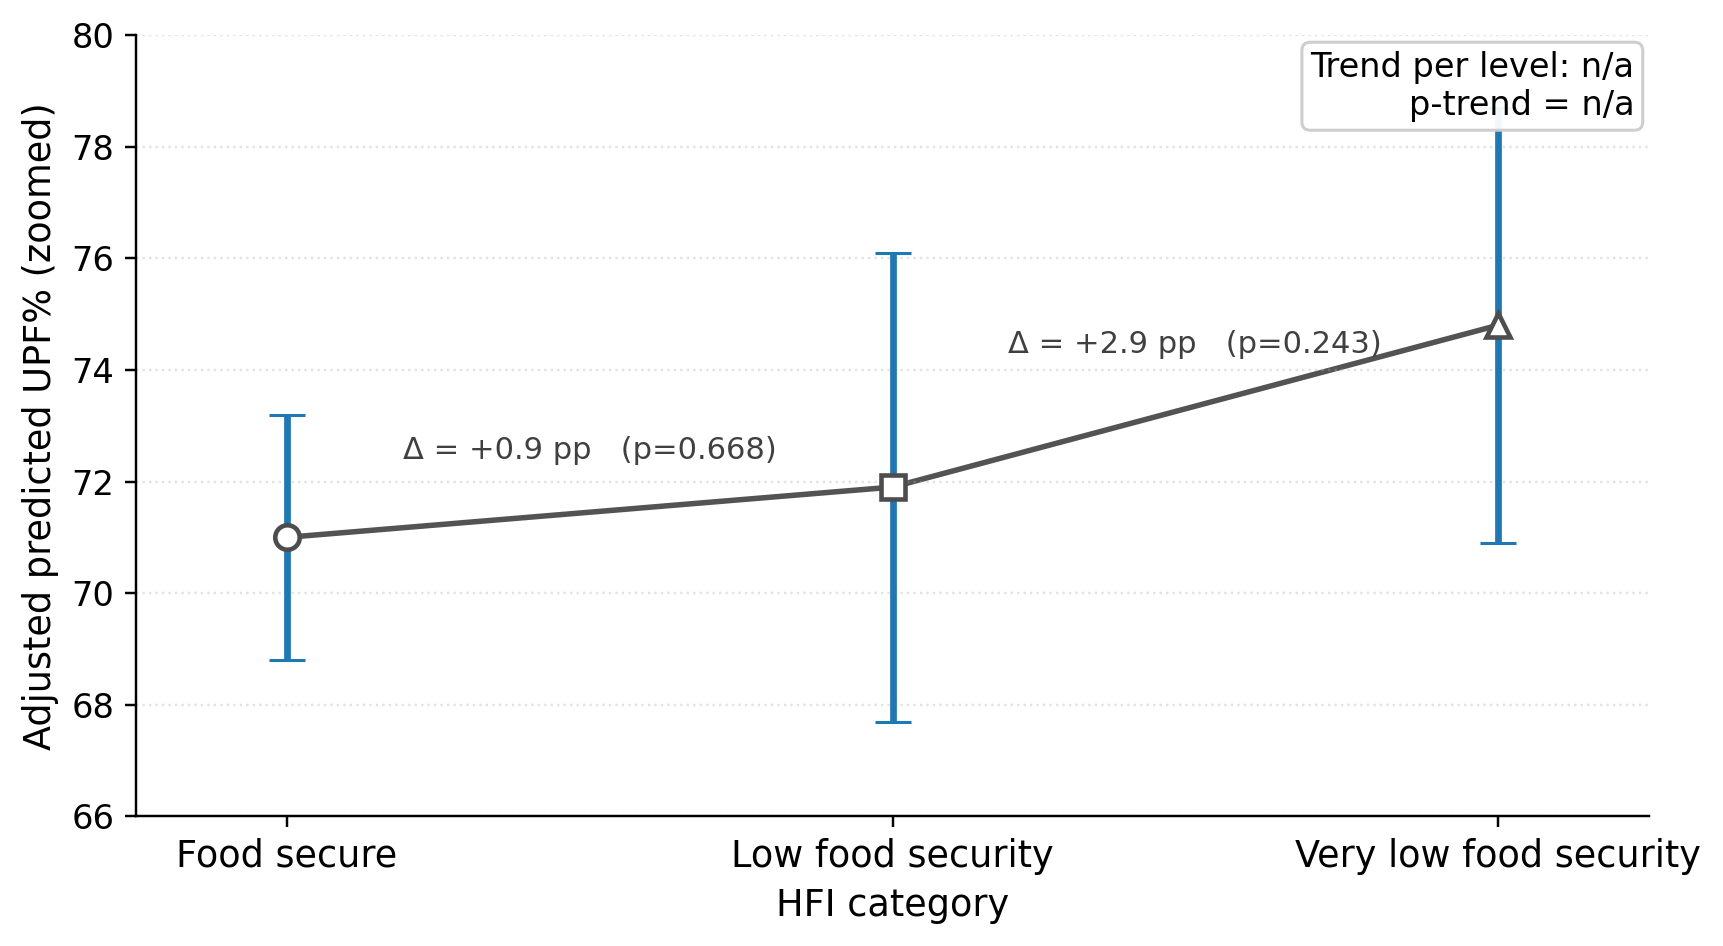

DEBUG shapes -> means3: (3,) | yerr3: (2, 3)


In [40]:
# === Figure 6 (clean zoom + pairwise tests) — 完整稳健版 ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) 依赖：需要已有 res_cat 与 linear_combo（用于 pairwise 对比）
tL = "C(HFI_category, Treatment(reference='Food secure'))[T.Low food security]"
tV = "C(HFI_category, Treatment(reference='Food secure'))[T.Very low food security]"
est_LF, ci_LF, p_LF = linear_combo(res_cat, {tL: 1})           # Food secure → Low
est_VL, ci_VL, p_VL = linear_combo(res_cat, {tV: 1, tL: -1})   # Low → Very low
pair_info = {(0,1): {"p": p_LF, "ci": ci_LF}, (1,2): {"p": p_VL, "ci": ci_VL}}
def stars(p): return "***" if p<0.001 else "**" if p<0.01 else "*" if p<0.05 else ""

# 1) 从表里抽取三组均值和CI；找不到则回退到文本数值
def get_threecat_from_table():
    for cand in ["table4_steps", "table4", "Table4_HFI_threecat"]:
        if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
            df = globals()[cand].copy()
            # 兼容可能的列名变体
            col_cat = [c for c in df.columns if "category" in c.lower()][0]
            col_mean = [c for c in df.columns if "mean" in c.lower()][0]
            col_ci   = [c for c in df.columns if "95%" in c or "ci" in c.lower()][0]
            # 只保留三行（Food secure / Low / Very low 顺序）
            order = ["Food secure","Low food security","Very low food security"]
            df[col_cat] = df[col_cat].astype(str)
            # 容错：去掉可能的多余空格
            mapper = {
                "Food secure":"Food secure",
                "Low food security":"Low food security",
                "Very low food security":"Very low food security"
            }
            df[col_cat] = df[col_cat].map(lambda s: mapper.get(s.strip(), s))
            df = df.set_index(col_cat).reindex(order).reset_index()
            cats3  = df[col_cat].tolist()
            means3 = pd.to_numeric(df[col_mean], errors="coerce").to_numpy(dtype=float)
            # 解析 CI（允许 68.8–73.2 或 68.8-73.2）
            ci_txt = df[col_ci].astype(str).str.replace("–","-", regex=False)
            lo3 = pd.to_numeric(ci_txt.str.split("-", n=1, expand=True)[0], errors="coerce").to_numpy(dtype=float)
            hi3 = pd.to_numeric(ci_txt.str.split("-", n=1, expand=True)[1], errors="coerce").to_numpy(dtype=float)
            yerr3 = np.vstack([means3 - lo3, hi3 - means3])  # (2,3)
            if np.any(np.isnan(means3)) or np.any(np.isnan(yerr3)):
                raise ValueError("Parsed NaN from table.")
            return cats3, means3, yerr3
    raise KeyError("no_table")

try:
    cats3, means3, yerr3 = get_threecat_from_table()
except Exception:
    # 回退：使用你文中的数值
    cats3  = ["Food secure","Low food security","Very low food security"]
    means3 = np.array([71.0, 71.9, 74.8], dtype=float)
    lo3    = np.array([68.8, 67.7, 70.9], dtype=float)
    hi3    = np.array([73.2, 76.1, 78.7], dtype=float)
    yerr3  = np.vstack([means3 - lo3, hi3 - means3])  # (2,3)

# 2) y 轴范围：包住 CI 并留 10% padding（裁到 0–100）
lo_all = means3 - yerr3[0]
hi_all = means3 + yerr3[1]
pad = max(1.0, 0.10 * (hi_all.max() - lo_all.min()))
yl  = max(0.0, np.floor(lo_all.min() - pad))
yh  = min(100.0, np.ceil (hi_all.max() + pad))

# 3) 画图
x = np.arange(3)
markers = ['o','s','^']
mfc, mec = 'white', '0.3'

plt.rcParams.update({"figure.dpi":220,"axes.titlesize":15,"axes.labelsize":12,
                     "xtick.labelsize":12,"ytick.labelsize":11})
fig, ax = plt.subplots(figsize=(8.0, 4.4))
ax.errorbar(x, means3, yerr=yerr3, fmt='none', capsize=6, elinewidth=2.2, zorder=2)
for i in range(3):
    ax.plot(x[i], means3[i], markers[i], ms=8, mfc=mfc, mec=mec, mew=1.5, zorder=3)
ax.plot(x, means3, '-', lw=1.8, color='0.25', alpha=0.9, zorder=1)

ax.set_ylim(yl, yh); ax.set_xlim(-0.25, 2.25)
ax.set_xticks(x, cats3)
ax.grid(axis='y', linestyle=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)

# 4) 相邻两档 Δ 标注
def stars(p): return "***" if p<0.001 else "**" if p<0.01 else "*" if p<0.05 else ""
gap = (yh - yl) * 0.06
for i in (0,1):
    midx  = (x[i] + x[i+1]) / 2
    midy  = (means3[i] + means3[i+1]) / 2 + gap
    delta = means3[i+1] - means3[i]
    info  = pair_info[(i, i+1)]
    label = f"Δ = {delta:+.1f} pp  {stars(info['p'])} (p={info['p']:.3f})"
    ax.text(midx, midy, label, ha='center', va='bottom', fontsize=10, color='0.25')

# 5) 右上角趋势徽标（若变量不存在就显示 n/a）
try:
    trend_text = f"Trend per level: {float(slope):+-.2f} pp\np-trend = {float(p_trend):.3f}"
except Exception:
    trend_text = "Trend per level: n/a\np-trend = n/a"
ax.text(0.99, 0.98, trend_text, transform=ax.transAxes, ha='right', va='top',
        fontsize=11, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.95))

# —— 轴标签（保留），不要标题 ——
ax.set_xlabel("HFI category")                         # 横轴：三类名称已在 xticks，这里补充轴名
ax.set_ylabel("Adjusted predicted UPF% (zoomed)")     # 纵轴：模型调整后的 UPF%
ax.set_title("")                                      # 确保没有标题（清空）
# 如果曾用过 suptitle，可顺带清空：
# fig.suptitle("")

plt.tight_layout(); plt.show()

print("DEBUG shapes -> means3:", means3.shape, "| yerr3:", yerr3.shape)


## 5.2 探索性交互：HFI × I(child_numbers≥3) （附录）

In [24]:
# ===== Exploratory interaction: HFI × I(child_numbers ≥ 3) — print only =====
import numpy as np, pandas as pd

# 1) 构造二元指示变量
df_model["many_children"] = (pd.to_numeric(df_model["child_numbers"], errors="coerce") >= 3).astype("int")

cols_c3 = [OUTCOME, "HFI_binary", "age_participant",
           "gender_participant", "ethn_participant", "child_numbers", "many_children"]

dat_c3 = df_model[cols_c3].copy()
# 强制为数值（以免混入字符串）
for c in ["HFI_binary","age_participant","child_numbers","many_children"]:
    dat_c3[c] = pd.to_numeric(dat_c3[c], errors="coerce")
dat_c3 = dat_c3.dropna().copy()

print(f"N (for children interaction): {len(dat_c3)}")

# 2) 设定模型：含主效应 + 交互
form_c3 = (
    f"{OUTCOME} ~ HFI_binary + many_children + HFI_binary:many_children"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
# 说明：同时加入“child_numbers(连续)” 与 “many_children(阈值)” 是在检验
# “≥3 的额外阈值效应”，many_children 可以理解为相对线性项的偏离。

res_c3 = fit_ols(form_c3, dat_c3, cov_type="HC3")

# 3) 交互系数（差异的差异）
e_int, ci_int, p_int = coef_ci(res_c3, "HFI_binary:many_children")
print(f"[交互项] HFI × I(≥3 children) = {e_int:+.2f} pp  (95%CI {ci_int[0]:.2f}, {ci_int[1]:.2f}); p={p_int:.3f}")

# 4) 简单斜率：<3 与 ≥3 的 HFI 效应
def simple_slope(many):
    combo = {"HFI_binary": 1.0}
    if many == 1:
        combo["HFI_binary:many_children"] = 1.0
    return linear_combo(res_c3, combo)  # (est, (lo,hi), p)

rows = []
lab_map = {0:"< 3 children", 1:"≥ 3 children"}
for g in [0,1]:
    est, ci, p = simple_slope(g)
    rows.append({"group": lab_map[g], "d": est, "lo": ci[0], "hi": ci[1], "p": p})

effects_ch = pd.DataFrame(rows)

# 5) 各组样本量
n_by = dat_c3.groupby("many_children")["HFI_binary"].size()
effects_ch["n"] = effects_ch["group"].map({lab_map[0]: int(n_by.get(0,0)),
                                           lab_map[1]: int(n_by.get(1,0))})

# 漂亮打印
print("\nHFI effect (insecure − secure) by children group:")
for r in effects_ch.itertuples():
    sig = "*" if r.p < 0.05 else ""
    print(f"  {r.group:>12}: {r.d:+.2f} pp [{r.lo:.2f}, {r.hi:.2f}]  p={r.p:.3f}{sig}")
print(f"\nOverall interaction p-value = {p_int:.3f}")

# 导出成表（论文表格/附录可用）
effects_ch.to_csv("output/children_interaction_effects.csv", index=False)
print("Saved: output/children_interaction_effects.csv")


N (for children interaction): 304
[交互项] HFI × I(≥3 children) = +0.37 pp  (95%CI -6.06, 6.79); p=0.911

HFI effect (insecure − secure) by children group:
  < 3 children: +2.26 pp [-1.69, 6.20]  p=0.263
  ≥ 3 children: +2.62 pp [-2.33, 7.57]  p=0.299

Overall interaction p-value = 0.911
Saved: output/children_interaction_effects.csv


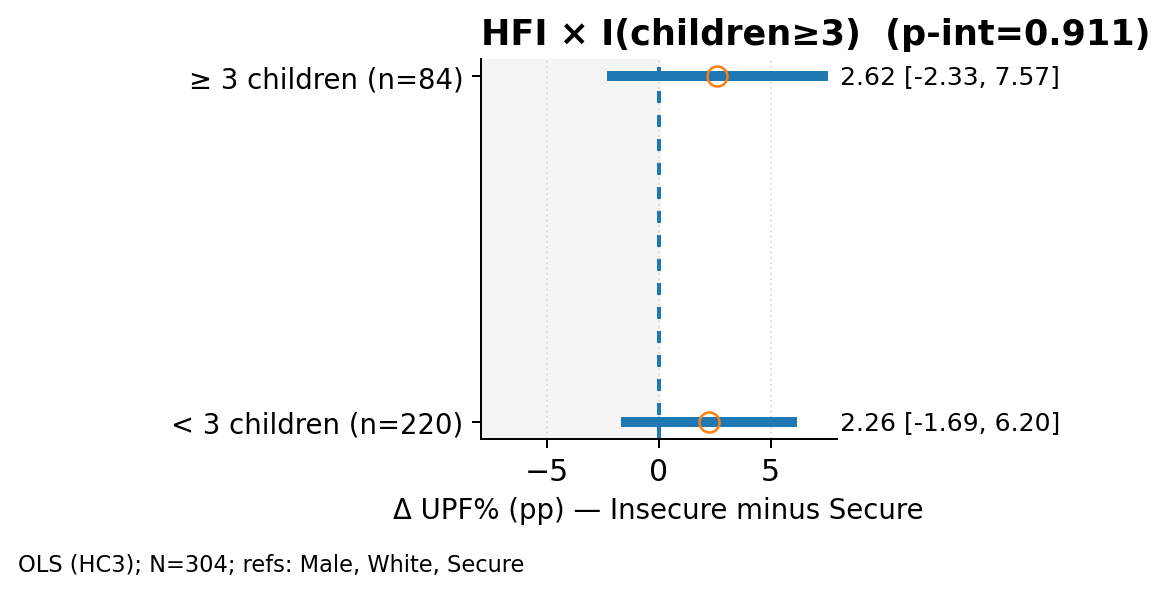

In [25]:
# ===== Figure Sx. HFI effect by children group (insecure − secure), 95% CI =====
import numpy as np, matplotlib.pyplot as plt

dfp = effects_ch.copy()
dfp["label"] = dfp.apply(lambda r: f"{r['group']} (n={int(r['n'])})", axis=1)
# 固定顺序：<3 在上，≥3 在下
order = ["< 3 children","≥ 3 children"]
dfp = dfp.set_index("group").loc[order].reset_index()

ypos = np.arange(len(dfp))
sig = dfp["p"].values < 0.05

fig_h = 2.8 + 0.35*len(dfp)
fig, ax = plt.subplots(figsize=(7.0, fig_h), dpi=180)

# 95% CI 横条
for i, (lo, hi) in enumerate(zip(dfp["lo"], dfp["hi"])):
    ax.hlines(ypos[i], xmin=lo, xmax=hi, lw=4.0, zorder=2)

# 点：显著实心、否则空心
ax.plot(dfp["d"].values[sig],  ypos[sig],  "o", ms=8, zorder=3)
ax.plot(dfp["d"].values[~sig], ypos[~sig], "o", ms=8, mfc="none", zorder=3)

# 0 线、对称范围
mx = 1.05 * max(abs(dfp["lo"].min()), abs(dfp["hi"].max()))
ax.set_xlim(-mx, mx)
ax.axvspan(-mx, 0, color="0.96", zorder=0)
ax.axvline(0, ls=(0,(3,3)), lw=1.6)

ax.set_yticks(ypos); ax.set_yticklabels(dfp["label"], fontsize=11)
ax.set_xlabel("Δ UPF% (pp) — Insecure minus Secure", fontsize=11)

# 右侧数值
def stars(pv): return "***" if pv<1e-3 else "**" if pv<1e-2 else "*" if pv<0.05 else ""
for yi, r in enumerate(dfp.itertuples()):
    ax.text(1.01, yi, f"{r.d:.2f} [{r.lo:.2f}, {r.hi:.2f}] {stars(r.p)}",
            transform=ax.get_yaxis_transform(), ha="left", va="center", fontsize=10)

ax.set_title(f"HFI × I(children≥3)  (p-int={p_int:.3f})",
             loc="left", fontsize=14, weight="bold", pad=6)
fig.text(0.12, 0.02, f"OLS (HC3); N={len(dat_c3)}; refs: Male, White, Secure",
         ha="left", va="bottom", fontsize=9)

ax.grid(axis='x', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout(rect=[0.22, 0.06, 0.98, 0.95])
# 若需要保存：
import pathlib; pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/children_interaction_forest.png", dpi=300, bbox_inches="tight")
plt.show()


## 5.4 年龄每 +1SD 的效应

In [26]:
# === Refit age(+1 SD) model, self-contained ===
import numpy as np, pandas as pd

# 构建同 Core-A 的自变量集合
cols = [OUTCOME, "HFI_binary", "age_participant",
        "gender_participant", "ethn_participant", "child_numbers"]
dat_ageSD = df_model[cols].copy()

# 强制转数值，并把年龄限制在 3–11（数据字典口径）
for c in ["HFI_binary","age_participant","child_numbers"]:
    dat_ageSD[c] = pd.to_numeric(dat_ageSD[c], errors="coerce")
dat_ageSD.loc[~dat_ageSD["age_participant"].between(3, 11), "age_participant"] = np.nan
dat_ageSD = dat_ageSD.dropna().copy()

# 标准化年龄 z_age（按样本均值/SD）
sd_age = dat_ageSD["age_participant"].std()
mu_age = dat_ageSD["age_participant"].mean()
dat_ageSD["z_age"] = (dat_ageSD["age_participant"] - mu_age) / sd_age

form_ageSD = (
    f"{OUTCOME} ~ HFI_binary + z_age"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
res_ageSD = fit_ols(form_ageSD, dat_ageSD, cov_type="HC3")

age_sd_est, age_sd_ci, age_sd_p = coef_ci(res_ageSD, "z_age")
print(f"年龄每 +1SD（SD={sd_age:.2f} 岁）UPF% 变化 = {age_sd_est:.2f} pp "
      f"(95%CI {age_sd_ci[0]:.2f}, {age_sd_ci[1]:.2f}), p={age_sd_p:.3f}; N={len(dat_ageSD)}")


年龄每 +1SD（SD=2.59 岁）UPF% 变化 = 1.28 pp (95%CI -0.04, 2.61), p=0.059; N=304


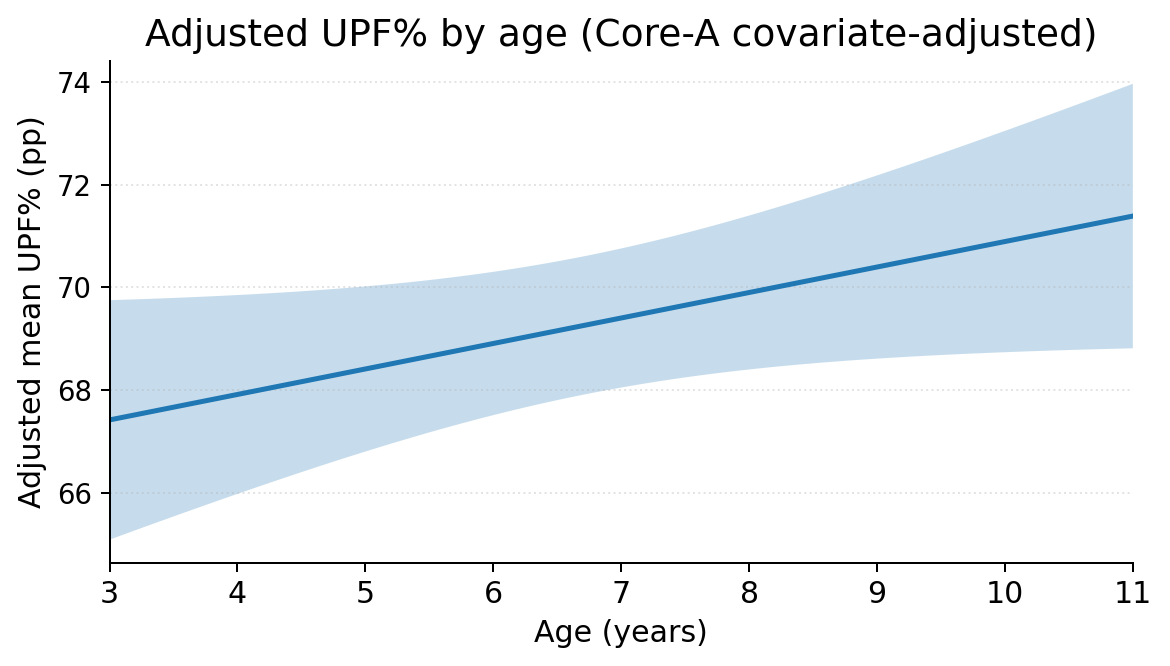

<Figure size 1408x1056 with 0 Axes>

In [27]:
# === Figure S?. Adjusted mean UPF% across age (with 95% CI) ===
import numpy as np, matplotlib.pyplot as plt

# 年龄网格（按数据/字典范围）
age_min = max(3.0, float(dat_ageSD["age_participant"].min()))
age_max = min(11.0, float(dat_ageSD["age_participant"].max()))
age_grid = np.linspace(age_min, age_max, 120)

# 从模型取设计矩阵与参数
X      = np.asarray(res_ageSD.model.exog)
names  = list(res_ageSD.model.exog_names)
i_age  = names.index("z_age")
beta   = np.asarray(res_ageSD.params)
covB   = np.asarray(res_ageSD.cov_params())
zstar  = _zcrit(0.05)

means, los, his = [], [], []
for a in age_grid:
    z = (a - mu_age) / sd_age            # 把年龄点换成 z_age
    Xtmp = X.copy()
    Xtmp[:, i_age] = z                   # 仅替换年龄列，其它协变量保持样本原值
    xbar = Xtmp.mean(axis=0)             # 平均预测 = 平均设计行 × beta
    mu  = float(xbar @ beta)
    var = float(xbar @ covB @ xbar)
    se  = np.sqrt(max(var, 0.0))
    means.append(mu); los.append(mu - zstar*se); his.append(mu + zstar*se)

means, los, his = map(np.asarray, (means, los, his))

fig, ax = plt.subplots(figsize=(6.6, 3.8), dpi=180)
ax.plot(age_grid, means, lw=2)
ax.fill_between(age_grid, los, his, alpha=0.25)
ax.set_xlim(age_min, age_max)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Adjusted mean UPF% (pp)")
ax.set_title("Adjusted UPF% by age (Core-A covariate-adjusted)")
ax.grid(axis='y', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.show()

#保存
import pathlib; pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/figureS4_age_effect.png", dpi=300, bbox_inches="tight")

# Table

In [28]:
# 在单元格里先安装
%pip install -q XlsxWriter

# 然后照原来的写法导出
with pd.ExcelWriter("/content/drive/MyDrive/UPF-HFI/Model/outcome/sample_tables.xlsx",
                    engine="xlsxwriter") as xw:
    table2.to_excel(xw, index=False, sheet_name="Table2_covariates")
    table3A.to_excel(xw, index=False, sheet_name="Table3_overall")
    table3B.to_excel(xw, index=False, sheet_name="Table3_by_ethnicity")


NameError: name 'table2' is not defined

In [ ]:
# === Sample tables (unadjusted) from df_model ===============================
import pandas as pd
import numpy as np

def _pct(n, d, digits=1):
    return None if d==0 else round(100.0*n/d, digits)

def build_sample_tables(df_model, outcome_col="weighted_upf_percent"):
    """
    输入：df_model（已合并的数据框）
    输出：table2_covariates, table3_overall, table3_by_ethnicity 三个 DataFrame
    约定：HFI_binary 1=food-insecure, 0=food-secure；gender 1=Male, 2=Female
    """

    needed = ["HFI_binary", "age_participant", "gender_participant",
              "ethn_participant", "child_numbers"]
    missing_cols = [c for c in needed if c not in df_model.columns]
    if missing_cols:
        raise ValueError(f"df_model 缺少列：{missing_cols}")

    # ---- 标准化分类值（不改你原始列，只做副本）----
    d = df_model.copy()

    # 族裔：把 'All other ethnicities' 统一成 'Other'
    eth = d["ethn_participant"].astype("string").str.strip()
    eth = eth.replace({"All other ethnicities":"Other", "all other ethnicities":"Other"})
    # 只保留我们关注的三类；其余记为缺失
    eth = eth.where(eth.isin(["White","Asian","Other"]))
    d["eth3"] = pd.Categorical(eth, categories=["White","Asian","Other"])

    # 性别：1=Male, 2=Female（保持与你模型一致）
    sex_map = {1:"Boys", 2:"Girls", "1":"Boys", "2":"Girls"}
    sex = pd.to_numeric(d["gender_participant"], errors="coerce").map(sex_map)
    d["sex2"] = pd.Categorical(sex, categories=["Boys","Girls"])

    # 家庭孩子数：按 1/2/3+ 归并
    kids = pd.to_numeric(d["child_numbers"], errors="coerce")
    kids_cat = pd.Series(pd.NA, index=kids.index, dtype="object")
    kids_cat[kids==1] = "1"
    kids_cat[kids==2] = "2"
    kids_cat[kids>=3] = "3+"
    d["kids3"] = pd.Categorical(kids_cat, categories=["1","2","3+"])

    # HFI：1=不安全, 0=安全
    hfi = pd.to_numeric(d["HFI_binary"], errors="coerce")
    d["HFI_bin"] = hfi

    N = len(d)

    # ===== Table 2: 协变量样本特征（含缺失） =====
    rows = []

    # Age
    age = pd.to_numeric(d["age_participant"], errors="coerce")
    rows.append(["Age (years)", "Mean (SD)", np.nan,
                 f"{np.nanmean(age):.2f} ({np.nanstd(age, ddof=1):.2f})",
                 f"{age.isna().sum()} ({_pct(age.isna().sum(), N)})"])

    # Sex
    for cat in ["Boys","Girls"]:
        n = (d["sex2"]==cat).sum()
        rows.append(["Sex", cat, int(n), f"{_pct(n, N):.1f}", ""])
    rows.append(["Sex", "Missing", int(d["sex2"].isna().sum()),
                 f"{_pct(d['sex2'].isna().sum(), N):.1f}", ""])

    # Ethnicity
    for cat in ["White","Asian","Other"]:
        n = (d["eth3"]==cat).sum()
        rows.append(["Ethnicity", cat, int(n), f"{_pct(n, N):.1f}", ""])
    rows.append(["Ethnicity", "Missing", int(d["eth3"].isna().sum()),
                 f"{_pct(d['eth3'].isna().sum(), N):.1f}", ""])

    # Number of children
    for cat in ["1","2","3+"]:
        n = (d["kids3"]==cat).sum()
        rows.append(["No. of children in household", cat, int(n), f"{_pct(n, N):.1f}", ""])
    rows.append(["No. of children in household", "Missing", int(d["kids3"].isna().sum()),
                 f"{_pct(d['kids3'].isna().sum(), N):.1f}", ""])

    table2 = pd.DataFrame(rows, columns=["Variable","Category","n","% / value","Missing, n (%)"])

    # ===== Table 3: HFI 总体 + 按族裔 =====
    # A. Overall
    n_insec = int((d["HFI_bin"]==1).sum())
    n_sec   = int((d["HFI_bin"]==0).sum())
    n_hfi_miss = int(d["HFI_bin"].isna().sum())
    table3_overall = pd.DataFrame({
        "HFI status":["Food insecure","Food secure","Missing"],
        "n":[n_insec, n_sec, n_hfi_miss],
        "%":[_pct(n_insec,N), _pct(n_sec,N), _pct(n_hfi_miss,N)]
    })

    # B. By ethnicity (within-ethnicity percentages)
    by_rows = []
    for g in ["White","Asian","Other"]:
        sub = d.loc[d["eth3"]==g]
        ntot = len(sub)
        if ntot==0:
            by_rows.append([g, 0, None, 0, 0])
            continue
        nin = int((sub["HFI_bin"]==1).sum())
        nse = int((sub["HFI_bin"]==0).sum())
        by_rows.append([g, nin, _pct(nin, ntot), nse, ntot])
    table3_by_eth = pd.DataFrame(by_rows,
                                 columns=["Ethnicity","Food insecure, n","% within ethnicity",
                                          "Food secure, n","n total"])

    # 美化百分比显示（None 保留为空白）
    for col in ["%","% within ethnicity","% / value"]:
        if col in table2.columns:
            pass
        if col in table3_overall.columns:
            table3_overall[col] = table3_overall[col].map(lambda x: "" if x is None else f"{x:.1f}")
        if col in table3_by_eth.columns:
            table3_by_eth[col] = table3_by_eth[col].map(lambda x: "" if x is None else f"{x:.1f}")

    return table2, table3_overall, table3_by_eth

# —— 用法（df_model 已在你上面的代码里生成） ——
table2, table3A, table3B = build_sample_tables(df_model)

# 可选：导出到 Excel
with pd.ExcelWriter("/content/drive/MyDrive/UPF-HFI/Model/outcome/sample_tables.xlsx",
                    engine="xlsxwriter") as xw:
    table2.to_excel(xw, index=False, sheet_name="Table2_covariates")
    table3A.to_excel(xw, index=False, sheet_name="Table3_overall")
    table3B.to_excel(xw, index=False, sheet_name="Table3_by_ethnicity")

print("已生成：Table 2（协变量）、Table 3A（HFI总体）、Table 3B（HFI×族裔）。")


In [ ]:
# ----- 统一口径：使用 Core-A 的分析样本 -----
OUTCOME = "weighted_upf_percent"
keep_cols = ["UserID_clean", OUTCOME, "HFI_binary",
             "age_participant", "gender_participant",
             "ethn_participant", "child_numbers"]

d = df_model[keep_cols].copy()

# 数值化 & 丢失统一处理（保证与 Core-A 一致）
for c in [OUTCOME, "HFI_binary", "age_participant", "gender_participant", "child_numbers"]:
    d[c] = pd.to_numeric(d[c], errors="coerce")
# UPF 合法范围
d.loc[~d[OUTCOME].between(0, 100), OUTCOME] = np.nan

# 丢失：六列都不能缺
d = d.dropna(subset=[OUTCOME, "HFI_binary", "age_participant",
                     "gender_participant", "ethn_participant", "child_numbers"]).copy()

# 合并后若同一ID重复，保留第一条
d = d.drop_duplicates(subset="UserID_clean").copy()

# 族裔三类（与 3.1 完全一致）
eth = d["ethn_participant"].astype("string").str.strip()
eth = eth.replace({"All other ethnicities":"Other", "all other ethnicities":"Other"})
eth = eth.where(eth.isin(["White","Asian","Other"]))
d["eth3"] = pd.Categorical(eth, categories=["White","Asian","Other"])

# ------------- 产出 Table 3（总体 + 按族裔，未调整） -------------
N = len(d)
# A. Overall
tbl_overall = d["HFI_binary"].value_counts().reindex([1,0], fill_value=0)
table3_overall = pd.DataFrame({
    "HFI status": ["Food insecure", "Food secure"],
    "n": [int(tbl_overall.loc[1]), int(tbl_overall.loc[0])],
    "%": [round(100*tbl_overall.loc[1]/N, 1), round(100*tbl_overall.loc[0]/N, 1)]
})

# B. By ethnicity（行内百分比）
ct = pd.crosstab(d["eth3"], d["HFI_binary"]).reindex(index=["White","Asian","Other"],
                                                     columns=[1,0], fill_value=0)
ct.index.name = "Ethnicity"   # 避免 KeyError
table3_by_eth = (ct.rename(columns={1:"Food insecure, n", 0:"Food secure, n"})
                   .reset_index())
table3_by_eth["n total"] = table3_by_eth["Food insecure, n"] + table3_by_eth["Food secure, n"]
table3_by_eth["% within ethnicity"] = (100*table3_by_eth["Food insecure, n"] /
                                       table3_by_eth["n total"]).round(1)

# ------------- 审计核对（必须全部 True / 正确数） -------------
print("N（应为 304）:", N)
print("族裔合计（应为 304）:", int(table3_by_eth["n total"].sum()))
print("各族裔 n total（应为 [167, 99, 38]）:",
      table3_by_eth["n total"].astype(int).tolist())
print("核对：不安全人数分层之和 == 总体不安全人数：",
      int(table3_by_eth["Food insecure, n"].sum()) == int(table3_overall.loc[0,"n"]))

# ------------- 显示（不会再报 Ethnicity KeyError） -------------
print("\nTable 3A — overall\n", table3_overall)
print("\nTable 3B — by ethnicity (row %)\n",
      table3_by_eth[["Ethnicity","Food insecure, n","% within ethnicity",
                     "Food secure, n","n total"]])


In [ ]:
# 用前面统一口径后的 d（N=304；含 OUTCOME='weighted_upf_percent' 和 d['eth3']=White/Asian/Other）

g = d.groupby("eth3")["weighted_upf_percent"]
table_upf_by_eth = (
    g.agg(n="count",
          mean=lambda x: x.mean(),
          sd=lambda x: x.std(ddof=1))
     .reset_index()
     .rename(columns={"eth3":"Ethnicity",
                      "mean":"Mean UPF% (unadjusted)",
                      "sd":"SD"})
)

# 可选：整体一行
overall = d["weighted_upf_percent"].agg(n="count", mean="mean", sd=lambda x: x.std(ddof=1))
overall.name = "Overall"
print(table_upf_by_eth)
print("\nOverall:", overall.to_dict())


In [ ]:
# 已有 d（N=304；含 d['eth3'] 和 'weighted_upf_percent'）
table_upf_by_eth = (
    d.groupby("eth3")["weighted_upf_percent"]
     .agg(n="count", mean="mean", sd=lambda x: x.std(ddof=1))
     .reset_index().rename(columns={"eth3":"Ethnicity",
                                    "mean":"Mean UPF% (unadjusted)",
                                    "sd":"SD"})
)
table_upf_by_eth["Mean UPF% (unadjusted)"] = table_upf_by_eth["Mean UPF% (unadjusted)"].round(1)
table_upf_by_eth["SD"] = table_upf_by_eth["SD"].round(2)

# 导出
with pd.ExcelWriter("/content/drive/MyDrive/UPF-HFI/Model/outcome/unadjusted_UPF_by_ethnicity.xlsx",
                    engine="openpyxl") as xw:
    table_upf_by_eth.to_excel(xw, index=False, sheet_name="UPF_by_ethnicity")


In [ ]:
# ===== Core-A 族裔分层 HFI 构成表（与回归样本完全一致） =====
import numpy as np, pandas as pd

OUTCOME = "weighted_upf_percent"
assert OUTCOME in df_model.columns

keep_cols = ["UserID_clean", OUTCOME, "HFI_binary",
             "age_participant", "gender_participant",
             "ethn_participant", "child_numbers"]
d = df_model[keep_cols].copy()

# 数值化统一
for c in [OUTCOME, "HFI_binary", "age_participant", "gender_participant", "child_numbers"]:
    d[c] = pd.to_numeric(d[c], errors="coerce")

# 目标变量合法范围（0–100）
d.loc[~d[OUTCOME].between(0, 100), OUTCOME] = np.nan

# Core-A 完整案例（六列都不缺）
d = d.dropna(subset=[OUTCOME, "HFI_binary", "age_participant",
                     "gender_participant", "ethn_participant", "child_numbers"]).copy()

# 若同一 ID 多条，仅保留第一条
if "UserID_clean" in d.columns:
    d = d.drop_duplicates(subset="UserID_clean").copy()

# 族裔三类（与 3.1 一致）
eth = d["ethn_participant"].astype("string").str.strip()
eth = eth.replace({"All other ethnicities": "Other", "all other ethnicities": "Other"})
eth = eth.where(eth.isin(["White", "Asian", "Other"]))
d["Ethnicity"] = pd.Categorical(eth, categories=["White", "Asian", "Other"])

# —— A) 总体（未调整）——
overall = d["HFI_binary"].value_counts().reindex([1, 0], fill_value=0)
table3_overall = pd.DataFrame({
    "HFI status": ["Food insecure", "Food secure"],
    "n": [int(overall.loc[1]), int(overall.loc[0])],
    "%": [round(100*overall.loc[1]/len(d), 1), round(100*overall.loc[0]/len(d), 1)]
})

# —— B) 按族裔（行内百分比）——
ct = pd.crosstab(d["Ethnicity"], d["HFI_binary"]).reindex(index=["White", "Asian", "Other"],
                                                          columns=[1, 0], fill_value=0)
ct = ct.rename(columns={1: "Food insecure, n", 0: "Food secure, n"}).reset_index()
ct["n total"] = ct["Food insecure, n"] + ct["Food secure, n"]
ct["% within ethnicity"] = (100 * ct["Food insecure, n"] / ct["n total"]).round(1)

# 列顺序与截图一致
table3_by_ethnicity = ct[["Ethnicity", "Food insecure, n", "% within ethnicity",
                          "Food secure, n", "n total"]]

# ===== 打印审计信息 =====
print(f"N（Core-A 分析样本）: {len(d)}")
print("各族裔 n total:", table3_by_ethnicity["n total"].astype(int).tolist())
print("总体不安全人数:", int(table3_overall.loc[0, "n"]))
print("分层不安全人数之和:", int(table3_by_ethnicity["Food insecure, n"].sum()))
print("\nTable 3B — by ethnicity (row %)\n", table3_by_ethnicity)
print("\nTable 3A — overall\n", table3_overall)

# ===== 保存为 Excel =====
# 如需与既有文件合并，可把路径改成 sample_tables.xlsx 并调整写入模式
out_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/Table3_coreA.xlsx"

# 需要 XlsxWriter（在 Colab 可先:  %pip install -q XlsxWriter）
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    table3_overall.to_excel(writer, index=False, sheet_name="Table3_overall")
    table3_by_ethnicity.to_excel(writer, index=False, sheet_name="Table3_by_ethnicity")

print("\nSaved to:", out_path)


In [ ]:
# ===== Table 4 — HFI three-category: means & stepwise changes =====
import pandas as pd, os

# —— 输入（采用你图/文中的数值） ——
means = {
    "Food secure":            {"mean":71.0, "ci":"68.8–73.2", "n":208},
    "Low food security":      {"mean":71.9, "ci":"67.7–76.1", "n":49},
    "Very low food security": {"mean":74.8, "ci":"70.9–78.7", "n":47},
}
# 相邻层级的对比（来自你的标注：Low−Secure=+0.9, Very low−Low=+2.9）
adjacent_deltas = {
    "Low food security":      {"delta": +0.9, "p": 0.668},   # Low vs Secure
    "Very low food security": {"delta": +2.9, "p": 0.243},   # Very low vs Low
}

rows = []
order = ["Food secure", "Low food security", "Very low food security"]
base_mean = means["Food secure"]["mean"]

for i, cat in enumerate(order):
    m = means[cat]["mean"]
    ci = means[cat]["ci"]
    n  = means[cat]["n"]
    # 相邻层级的增量（第一行无相邻对比）
    if i == 0:
        step_delta, p_step = None, None
    else:
        step_delta = adjacent_deltas[cat]["delta"]
        p_step     = adjacent_deltas[cat]["p"]
    # 累计相对 Food secure 的增量（描述性）
    cum_delta = None if i == 0 else (m - base_mean)

    rows.append({
        "HFI category": cat,
        "Adjusted mean UPF%": f"{m:.1f}",
        "95% CI": ci,
        "n": int(n),
        "Δ vs previous level (pp)": "—" if step_delta is None else f"{step_delta:+.1f}",
        "p (vs previous level)":    "—" if p_step is None     else f"{p_step:.3f}",
        "Cumulative Δ vs Food secure (pp)": "—" if cum_delta is None else f"{cum_delta:+.1f}",
    })

table4_steps = pd.DataFrame(rows)

# —— 审计打印 ——
print("Sum of n (should be 304):", int(pd.to_numeric(table4_steps["n"], errors="coerce").sum()))
print("\nTable 4 — HFI three-category: means & stepwise changes\n", table4_steps)

# —— 追加写入到 Excel ——
out_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/sample_tables.xlsx"
mode = "a" if os.path.exists(out_path) else "w"
try:
    import openpyxl  # to enable append mode
    with pd.ExcelWriter(out_path, engine="openpyxl", mode=mode, if_sheet_exists="replace") as xw:
        table4_steps.to_excel(xw, index=False, sheet_name="Table4_threecat_steps")
    print(f"\nSaved to: {out_path} -> [Table4_threecat_steps]")
except Exception as e:
    # 备选保存
    alt_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/Table4_threecat_steps.xlsx"
    with pd.ExcelWriter(alt_path, engine="xlsxwriter") as xw:
        table4_steps.to_excel(xw, index=False, sheet_name="Table4_threecat_steps")
    print(f"\nopenpyxl append failed ({e}). Saved to: {alt_path}")


# 作废

# 6. Table（描述性摘要）

In [ ]:
import pandas as pd, numpy as np
from scipy import stats
import statsmodels.formula.api as smf

# === 列名映射（按你的表来；不一致就改这里） ===
COL = dict(
    y="weighted_upf_percent",
    HFI_bin="HFI_binary",               # 0=secure, 1=insecure
    age="age_participant",
    sex="gender_participant",           # Male=1, Female=0（Male参照）
    ethn="ethn_participant",            # White / Asian / All other ethnicities
    children="child_numbers",
    income="income",
    employ="employ",
    HFI_3="HFI_3cat"                    # 可选：三分类 HFI
)

# 统一族裔标签 & 顺序
DF = df.copy()  # 你的DataFrame
DF[COL["ethn"]] = DF[COL["ethn"]].replace({"All other ethnicities":"Other"})
eth_order = pd.CategoricalDtype(categories=["White","Asian","Other"], ordered=True)
DF[COL["ethn"]] = DF[COL["ethn"]].astype(eth_order)

# UPF% 越界置缺
DF.loc[(DF[COL["y"]]<0)|(DF[COL["y"]]>100), COL["y"]] = np.nan

# 格式与显著性
def pstar(p):
    return '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''
def fmt_ci(b, lo, hi, p):
    return f"{b:.1f} [{lo:.1f}, {hi:.1f}]; p={p:.3f}{pstar(p)}"
def mean_sd_n(x):
    return pd.Series({"mean":x.mean(), "sd":x.std(), "n":x.notna().sum()})


In [ ]:
rows = []
# Overall
rows.append(("Overall",)+tuple(mean_sd_n(DF[COL["y"]]).values))
# By HFI
for v,label in [(0,"Food secure"),(1,"Food insecure")]:
    s = DF.loc[DF[COL["HFI_bin"]]==v, COL["y"]]
    rows.append((f"By HFI — {label}",)+tuple(mean_sd_n(s).values))
# By ethnicity（按预设顺序）
for g in eth_order.categories:
    s = DF.loc[DF[COL["ethn"]]==g, COL["y"]]
    rows.append((f"By ethnicity — {g}",)+tuple(mean_sd_n(s).values))

tbl2 = pd.DataFrame(rows, columns=["Stratum","mean","sd","n"])
tbl2["UPF% mean (SD)"] = tbl2.apply(lambda r:f"{r['mean']:.1f} ({r['sd']:.1f})", axis=1)
tbl2 = tbl2[["Stratum","UPF% mean (SD)","n"]]

# 好看一点的导出
tbl2.to_csv("table2_unadjusted_upf.csv", index=False)
print("Saved: table2_unadjusted_upf.csv")
tbl2


In [ ]:
# ====== ONE-CELL: 生成 “表3（已调整）” 全量两列表 ======
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

# -------- 小工具 --------
def fit_ols(formula, data, cov_type="HC3"):
    return smf.ols(formula, data=data).fit(cov_type=cov_type)

def coef_ci(res, name):
    """返回 (b, lo, hi, p)；若找不到参数名直接抛错，便于定位。"""
    b = res.params[name]
    lo, hi = res.conf_int().loc[name]
    p = res.pvalues[name]
    return float(b), float(lo), float(hi), float(p)

def fmt(b, lo, hi, p):
    return f"{b:.1f} [{lo:.1f}, {hi:.1f}]; p={p:.3f}"

def wald_p_for_interactions(res, names):
    R = np.zeros((len(names), len(res.params)))
    for i, nm in enumerate(names):
        R[i, list(res.params.index).index(nm)] = 1.0
    return float(res.wald_test(R).pvalue)

# -------- 数据准备（与你当前环境一致）--------
DF = df_model.copy()                   # 用你的 df_model
OUTCOME = OUTCOME                      # 已在你环境中定义

# 统一族裔标签
DF["ethn_participant"] = DF["ethn_participant"].replace({"All other ethnicities":"Other"})
eth_levels = ["White","Asian","Other"]

# UPF% 越界置缺
DF.loc[(DF[OUTCOME] < 0) | (DF[OUTCOME] > 100), OUTCOME] = np.nan

# -------- Core-A --------
form_coreA = (
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
need_coreA = [OUTCOME,"HFI_binary","age_participant","gender_participant","ethn_participant","child_numbers"]
datA = DF[need_coreA].dropna().copy()

resA = fit_ols(form_coreA, datA)
b1, lo1, hi1, p1 = coef_ci(resA, "HFI_binary")

# -------- Core-B（HFI×ethnicity）--------
form_coreB = (
    f"{OUTCOME} ~ HFI_binary*C(ethn_participant, Treatment(reference='White'))"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + child_numbers"
)
resB = fit_ols(form_coreB, datA)

# White 层 = 主效应；Asian/Other = 主效应 + 对应交互
param_idx = resB.params.index.tolist()
def inter_name(level):
    for nm in param_idx:
        if nm.startswith("HFI_binary:") and f"[T.{level}]" in nm:
            return nm
    raise KeyError(f"找不到交互项：{level}")

by_eth = []
# White
by_eth.append(("White",) + coef_ci(resB, "HFI_binary"))
# Asian / Other
for lvl in ["Asian","Other"]:
    nm = inter_name(lvl)
    # 线性组合 β_HFI + β_(HFI×lvl)
    L = np.zeros(len(resB.params))
    L[param_idx.index("HFI_binary")] = 1.0
    L[param_idx.index(nm)] += 1.0
    est = float(L @ resB.params)
    se  = float(np.sqrt(L @ resB.cov_params() @ L))
    z   = est/se
    p   = 2*stats.norm.sf(abs(z))
    lo, hi = est-1.96*se, est+1.96*se
    by_eth.append((lvl, est, lo, hi, p))

p_inter = wald_p_for_interactions(resB, [inter_name("Asian"), inter_name("Other")])

# -------- 敏感性：HFI 三分类 + 趋势 --------
sens_rows = []
bT=loT=hiT=pT=np.nan
if "HFI_category" in DF.columns:        # 你的列名
    # 规范顺序
    order = ["Food secure","Low food security","Very low food security"]
    DF = DF.copy()
    DF = DF[need_coreA + ["HFI_category"]].dropna().copy()
    DF["HFI_category"] = pd.Categorical(DF["HFI_category"], categories=order, ordered=True)

    # (a) 类别模型（参照 Food secure）
    form_cat = (
        f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
        " + age_participant + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_cat = fit_ols(form_cat, DF)
    for lev, lab in [("Low food security","Low vs secure"),
                     ("Very low food security","Very low vs secure")]:
        nm = f"C(HFI_category, Treatment(reference='Food secure'))[T.{lev}]"
        sens_rows.append((lab,) + coef_ci(res_cat, nm))

    # (b) 线性趋势：0/1/2
    tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
    DF["_HFI_trend"] = DF["HFI_category"].map(tr_map).astype(float)
    form_tr = (
        f"{OUTCOME} ~ _HFI_trend + age_participant"
        " + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_tr = fit_ols(form_tr, DF)
    bT, loT, hiT, pT = coef_ci(res_tr, "_HFI_trend")

# -------- SES 稳健性：same-N / fresh-N --------
rows_ses = []
if {"income","employ"}.issubset(df_model.columns):
    # same-N
    ses_cols = need_coreA + ["income","employ"]
    dat_same = df_model[ses_cols].copy()
    for c in ["HFI_binary","age_participant","child_numbers","income"]:
        dat_same[c] = pd.to_numeric(dat_same[c], errors="coerce")
    dat_same = dat_same.dropna().copy()

    res_core_same = fit_ols(form_coreA, dat_same)
    form_plusSES  = form_coreA + " + income + C(employ)"
    res_plus_same = fit_ols(form_plusSES, dat_same)

    b_coreS, lo_coreS, hi_coreS, p_coreS = coef_ci(res_core_same,  "HFI_binary")
    b_SES_S, lo_SES_S, hi_SES_S, p_SES_S = coef_ci(res_plus_same, "HFI_binary")
    pct_change = (b_SES_S - b_coreS)/b_coreS*100 if b_coreS!=0 else np.nan

    rows_ses.append(("SES robustness — same-N (β1 change, %; N)",
                     f"{pct_change:.1f}% ; N={len(dat_same)}"))

    # fresh-N（各自可用样本）
    dat_coreF = df_model[need_coreA].copy()
    for c in ["HFI_binary","age_participant","child_numbers"]:
        dat_coreF[c] = pd.to_numeric(dat_coreF[c], errors="coerce")
    dat_coreF = dat_coreF.dropna().copy()

    dat_SESF  = df_model[ses_cols].copy()
    for c in ["HFI_binary","age_participant","child_numbers","income"]:
        dat_SESF[c] = pd.to_numeric(dat_SESF[c], errors="coerce")
    dat_SESF = dat_SESF.dropna().copy()

    res_coreF = fit_ols(form_coreA,  dat_coreF)
    res_SESF  = fit_ols(form_plusSES, dat_SESF)
    b_SESF, lo_SESF, hi_SESF, p_SESF = coef_ci(res_SESF, "HFI_binary")
else:
    b_SESF=lo_SESF=hi_SESF=p_SESF=np.nan

# -------- 组装两列表 --------
rows3 = []
rows3.append(("Core-A: insecure − secure (pp)", fmt(b1, lo1, hi1, p1)))

rows3.append(("Core-B (HFI×ethnicity):", ""))
for lbl, b, lo, hi, p in by_eth:
    rows3.append((f"  {lbl}: insecure − secure", fmt(b, lo, hi, p)))
rows3.append(("  p-interaction (Wald)", f"{p_inter:.3f}"))

# 敏感性
if len(sens_rows)>0:
    rows3.append(("Sensitivity (HFI three-level):", ""))
    for lab, b, lo, hi, p in sens_rows:
        rows3.append((f"  {lab}", fmt(b, lo, hi, p)))
    rows3.append(("  Linear trend (0→2, pp/level)", fmt(bT, loT, hiT, pT)))

# SES 稳健性
if len(rows_ses)>0:
    rows3.extend(rows_ses)
    if not np.isnan(b_SESF):
        rows3.append(("SES robustness — fresh-N (β1 + SES; N)",
                      f"{b_SESF:.1f} [{lo_SESF:.1f}, {hi_SESF:.1f}]; p={p_SESF:.3f}; N={len(dat_SESF)}"))

tbl3 = pd.DataFrame(rows3, columns=["Contrast / Estimand", "Value"])
tbl3.to_csv("table3_adjusted_effects.csv", index=False)
print("Saved: table3_adjusted_effects.csv")
tbl3


In [ ]:
# 在之前生成 tbl2 的基础上，追加“按子女数”分层
d = DF.copy()
d["child_ge3"] = (pd.to_numeric(d["child_numbers"], errors="coerce") >= 3)

def _mean_sd_n(x):
    return pd.Series({"mean":x.mean(), "sd":x.std(), "n":x.notna().sum()})

add_rows = []
for v,lab in [(False,"By children — <3"), (True,"By children — ≥3")]:
    sub = d.loc[d["child_ge3"]==v, OUTCOME]
    s = _mean_sd_n(sub)
    add_rows.append((lab, f"{s['mean']:.1f} ({s['sd']:.1f})", int(s['n'])))

# 也可用 0/1/2/3+ 的四档：把上面两行替换为下面注释
# d["child_4lvl"] = pd.cut(pd.to_numeric(d["child_numbers"], errors="coerce"),
#                          bins=[-0.5,0.5,1.5,2.5,100], labels=["0","1","2","3+"])
# for g, subdf in d.groupby("child_4lvl", observed=True):
#     s = _mean_sd_n(subdf[OUTCOME]); add_rows.append((f"By children — {g}", f"{s['mean']:.1f} ({s['sd']:.1f})", int(s['n'])))

tbl2_children = pd.DataFrame(add_rows, columns=["Stratum","UPF% mean (SD)","n"])
tbl2 = pd.concat([tbl2, tbl2_children], ignore_index=True)
tbl2.to_csv("table2_unadjusted_upf.csv", index=False)
tbl2


In [ ]:
# 在生成 tbl3 之后追加 “HFI × I(children ≥3)” 交互的两行与整体 p 值
from scipy import stats
import numpy as np, pandas as pd

dat_c3 = df_model[[OUTCOME,"HFI_binary","age_participant","gender_participant",
                   "ethn_participant","child_numbers"]].copy()
for c in ["HFI_binary","age_participant","child_numbers"]:
    dat_c3[c] = pd.to_numeric(dat_c3[c], errors="coerce")
dat_c3["many_children"] = (dat_c3["child_numbers"] >= 3).astype("int")
dat_c3 = dat_c3.dropna().copy()

form_c3 = (
    f"{OUTCOME} ~ HFI_binary + many_children + HFI_binary:many_children"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
res_c3 = smf.ols(form_c3, data=dat_c3).fit(cov_type="HC3")

# 交互项
b_int = res_c3.params["HFI_binary:many_children"]
se   = np.sqrt(res_c3.cov_params().loc["HFI_binary:many_children","HFI_binary:many_children"])
lo, hi = b_int - 1.96*se, b_int + 1.96*se
p_int  = res_c3.pvalues["HFI_binary:many_children"]

# <3 的 HFI 效应 = β_HFI； ≥3 的 HFI 效应 = β_HFI + 交互
b0, lo0, hi0, p0 = coef_ci(res_c3, "HFI_binary")
L = np.zeros(len(res_c3.params)); idx = list(res_c3.params.index)
L[idx.index("HFI_binary")] = 1; L[idx.index("HFI_binary:many_children")] += 1
est = float(L @ res_c3.params); se = float(np.sqrt(L @ res_c3.cov_params() @ L))
z = est/se; p1 = 2*stats.norm.sf(abs(z)); lo1, hi1 = est-1.96*se, est+1.96*se

rows_children = [
    ("Children interaction (HFI × I≥3):", ""),
    ("  <3 children: insecure − secure", f"{b0:.1f} [{lo0:.1f}, {hi0:.1f}]; p={p0:.3f}"),
    ("  ≥3 children: insecure − secure",  f"{est:.1f} [{lo1:.1f}, {hi1:.1f}]; p={p1:.3f}"),
    ("  p-interaction", f"{p_int:.3f}")
]

tbl3 = pd.concat([tbl3, pd.DataFrame(rows_children, columns=tbl3.columns)], ignore_index=True)
tbl3.to_csv("table3_adjusted_effects.csv", index=False)
tbl3


In [ ]:
# ====== ONE-CELL: 生成 “表3（已调整）”——含样本数的三列版 ======
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

# -------- 小工具 --------
def fit_ols(formula, data, cov_type="HC3"):
    return smf.ols(formula, data=data).fit(cov_type=cov_type)

def coef_ci(res, name):
    """返回 (b, lo, hi, p)；若找不到参数名直接抛错。"""
    b = res.params[name]
    lo, hi = res.conf_int().loc[name]
    p = res.pvalues[name]
    return float(b), float(lo), float(hi), float(p)

def fmt_pp(b, lo, hi, p, dec=1):
    f = f"{{:.{dec}f}}"
    return f"{f.format(b)} [{f.format(lo)}, {f.format(hi)}]; p={p:.3f}"

def wald_p_for_interactions(res, names):
    R = np.zeros((len(names), len(res.params)))
    for i, nm in enumerate(names):
        R[i, list(res.params.index).index(nm)] = 1.0
    return float(res.wald_test(R).pvalue)

def pct_str(n, N):
    return f"{n} ({(n/N)*100:.1f}%)"

# -------- 数据准备（与你当前环境一致）--------
DF = df_model.copy()
OUTCOME = OUTCOME

# 统一族裔标签 & 越界置缺
DF["ethn_participant"] = DF["ethn_participant"].replace({"All other ethnicities":"Other"})
eth_levels = ["White","Asian","Other"]
DF.loc[(DF[OUTCOME] < 0) | (DF[OUTCOME] > 100), OUTCOME] = np.nan

# Core-A 完整案例数据
need_coreA = [OUTCOME,"HFI_binary","age_participant","gender_participant","ethn_participant","child_numbers"]
datA = DF[need_coreA].dropna().copy()
N_overall = len(datA)

# -------- Core-A --------
form_coreA = (
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
resA = fit_ols(form_coreA, datA)
b1, lo1, hi1, p1 = coef_ci(resA, "HFI_binary")

# 年龄（每 +1 SD）的展示口径（不改变模型，仅换标度）
sd_age = float(datA["age_participant"].std(ddof=1))
b_age, lo_age, hi_age, p_age = coef_ci(resA, "age_participant")
b_ageSD, lo_ageSD, hi_ageSD = b_age*sd_age, lo_age*sd_age, hi_age*sd_age

# -------- Core-B（HFI×ethnicity）--------
form_coreB = (
    f"{OUTCOME} ~ HFI_binary*C(ethn_participant, Treatment(reference='White'))"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + child_numbers"
)
resB = fit_ols(form_coreB, datA)

param_idx = resB.params.index.tolist()
def inter_name(level):
    for nm in param_idx:
        if nm.startswith("HFI_binary:") and f"[T.{level}]" in nm:
            return nm
    raise KeyError(f"交互项缺失：{level}")

# 各族裔样本 n(%)
eth_counts = datA["ethn_participant"].value_counts().reindex(eth_levels).fillna(0).astype(int)
sample_eth = {lvl: pct_str(int(eth_counts[lvl]), N_overall) for lvl in eth_levels}

by_eth = []
# White = 主效应
by_eth.append(("White", sample_eth["White"],) + coef_ci(resB, "HFI_binary"))
# Asian / Other = 主效应 + 交互
for lvl in ["Asian","Other"]:
    nm = inter_name(lvl)
    L = np.zeros(len(resB.params))
    L[param_idx.index("HFI_binary")] = 1.0
    L[param_idx.index(nm)] += 1.0
    est = float(L @ resB.params)
    se  = float(np.sqrt(L @ resB.cov_params() @ L))
    z   = est/se
    p   = 2*stats.norm.sf(abs(z))
    lo, hi = est-1.96*se, est+1.96*se
    by_eth.append((lvl, sample_eth[lvl], est, lo, hi, p))

p_inter_eth = wald_p_for_interactions(resB, [inter_name("Asian"), inter_name("Other")])

# -------- 敏感性：HFI 三分类 + 趋势 --------
sens_rows = [] ; sample_low = sample_vlow = sample_trend = ""
if "HFI_category" in DF.columns:
    order = ["Food secure","Low food security","Very low food security"]
    DF_cat = DF[need_coreA + ["HFI_category"]].dropna().copy()
    DF_cat["HFI_category"] = pd.Categorical(DF_cat["HFI_category"], categories=order, ordered=True)
    counts_cat = DF_cat["HFI_category"].value_counts().reindex(order).fillna(0).astype(int)
    sample_low   = f"n={int(counts_cat['Low food security'])}"
    sample_vlow  = f"n={int(counts_cat['Very low food security'])}"
    sample_trend = f"N={len(DF_cat)}"

    # (a) 类别效应
    form_cat = (
        f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
        " + age_participant + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_cat = fit_ols(form_cat, DF_cat)
    nm_low  = "C(HFI_category, Treatment(reference='Food secure'))[T.Low food security]"
    nm_vlow = "C(HFI_category, Treatment(reference='Food secure'))[T.Very low food security]"
    sens_rows.append(("Low food security", sample_low,) + coef_ci(res_cat, nm_low))
    sens_rows.append(("Very low food security", sample_vlow,) + coef_ci(res_cat, nm_vlow))

    # (b) 线性趋势
    tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
    DF_cat["_HFI_trend"] = DF_cat["HFI_category"].map(tr_map).astype(float)
    form_tr = (
        f"{OUTCOME} ~ _HFI_trend + age_participant"
        " + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_tr = fit_ols(form_tr, DF_cat)
    bT, loT, hiT, pT = coef_ci(res_tr, "_HFI_trend")

# -------- SES 稳健性：same-N / fresh-N --------
# -------- SES 稳健性：same-N / fresh-N（修复 categorical 被数值化的问题）--------
ses_same_row = ses_fresh_row = None
if {"income","employ"}.issubset(df_model.columns):
    ses_cols = need_coreA + ["income","employ"]

    # === same-N：与 +SES 使用完全相同的数据行 ===
    dat_same = df_model[ses_cols].copy()

    # 只数值化真正的数值列；分类变量保持原始标签
    for c in ["HFI_binary","age_participant","child_numbers","income"]:
        dat_same[c] = pd.to_numeric(dat_same[c], errors="coerce")

    # 这些列必须同时非缺失，才能进入 same-N 两个模型
    dat_same = dat_same.dropna(
        subset=["HFI_binary","age_participant","gender_participant",
                "ethn_participant","child_numbers","income","employ"]
    ).copy()

    # 仍然确保性别/族裔是 category（避免 patsy 误判）
    dat_same["gender_participant"] = dat_same["gender_participant"].astype("category")
    dat_same["ethn_participant"]   = dat_same["ethn_participant"].astype("category")
    dat_same["employ"]             = dat_same["employ"].astype("category")

    res_core_same = fit_ols(form_coreA, dat_same)
    form_plusSES  = form_coreA + " + income + C(employ)"
    res_plus_same = fit_ols(form_plusSES, dat_same)

    b_coreS, *_                    = coef_ci(res_core_same,  "HFI_binary")
    b_SES_S, lo_SES_S, hi_SES_S, p_SES_S = coef_ci(res_plus_same, "HFI_binary")
    d_abs  = b_SES_S - b_coreS
    d_pct  = (d_abs / b_coreS * 100) if b_coreS != 0 else np.nan
    ses_same_row = ("SES robustness — same-N (Δ vs Core-A)",
                    f"N={len(dat_same)}",
                    f"β1(+SES)={fmt_pp(b_SES_S, lo_SES_S, hi_SES_S, p_SES_S, dec=2)}; Δ={d_abs:+.2f} (+{d_pct:.1f}%)")

    # === fresh-N：Core-A 用可用样本；+SES 用有 SES 的样本 ===
    dat_coreF = df_model[need_coreA].copy()
    for c in ["HFI_binary","age_participant","child_numbers"]:
        dat_coreF[c] = pd.to_numeric(dat_coreF[c], errors="coerce")
    dat_coreF = dat_coreF.dropna(
        subset=["HFI_binary","age_participant","gender_participant",
                "ethn_participant","child_numbers"]
    ).copy()
    dat_coreF["gender_participant"] = dat_coreF["gender_participant"].astype("category")
    dat_coreF["ethn_participant"]   = dat_coreF["ethn_participant"].astype("category")

    dat_SESF = df_model[ses_cols].copy()
    for c in ["HFI_binary","age_participant","child_numbers","income"]:
        dat_SESF[c] = pd.to_numeric(dat_SESF[c], errors="coerce")
    dat_SESF = dat_SESF.dropna(
        subset=["HFI_binary","age_participant","gender_participant",
                "ethn_participant","child_numbers","income","employ"]
    ).copy()
    dat_SESF["gender_participant"] = dat_SESF["gender_participant"].astype("category")
    dat_SESF["ethn_participant"]   = dat_SESF["ethn_participant"].astype("category")
    dat_SESF["employ"]             = dat_SESF["employ"].astype("category")

    res_SESF  = fit_ols(form_plusSES, dat_SESF)
    res_coreF = fit_ols(form_coreA,  dat_coreF)

    b_SESF, lo_SESF, hi_SESF, p_SESF = coef_ci(res_SESF, "HFI_binary")
    b_coreF, *_ = coef_ci(res_coreF, "HFI_binary")
    d_abs_F = b_SESF - b_coreF
    d_pct_F = (d_abs_F / b_coreF * 100) if b_coreF != 0 else np.nan

    ses_fresh_row = ("SES robustness — fresh-N (Δ vs Core-A)",
                     f"Core-A N={len(dat_coreF)} / +SES N={len(dat_SESF)}",
                     f"β1(+SES)={fmt_pp(b_SESF, lo_SESF, hi_SESF, p_SESF, dec=2)}; Δ={d_abs_F:+.2f} (+{d_pct_F:.1f}%)")

    # 与 Core-A（全部可用样本）比较
    res_coreF = fit_ols(form_coreA, dat_coreF)
    b_coreF, *_ = coef_ci(res_coreF, "HFI_binary")
    d_abs_F = b_SESF - b_coreF
    d_pct_F = (d_abs_F / b_coreF * 100) if b_coreF != 0 else np.nan
    ses_fresh_row = ("SES robustness — fresh-N (Δ vs Core-A)",
                     f"Core-A N={len(dat_coreF)} / +SES N={len(dat_SESF)}",
                     f"β1(+SES)={fmt_pp(b_SESF, lo_SESF, hi_SESF, p_SESF, dec=2)}; Δ={d_abs_F:+.2f} (+{d_pct_F:.1f}%)")

# -------- 儿童交互：HFI × I(≥3 子女) --------
child_rows = [] ; p_inter_child = np.nan
datC = datA.copy()
datC["_Ige3"] = (datC["child_numbers"] >= 3).astype(int)
form_child = (
    f"{OUTCOME} ~ HFI_binary*_Ige3 + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
resC = fit_ols(form_child, datC)
# <3: HFI 主效应
b_lt, lo_lt, hi_lt, p_lt = coef_ci(resC, "HFI_binary")
n_lt = int((datC["_Ige3"]==0).sum())
# ≥3: HFI + 交互
nm_c = "HFI_binary:_Ige3"
L = np.zeros(len(resC.params))
L[list(resC.params.index).index("HFI_binary")] = 1.0
L[list(resC.params.index).index(nm_c)] += 1.0
est = float(L @ resC.params)
se  = float(np.sqrt(L @ resC.cov_params() @ L))
z   = est/se
p_ge = 2*stats.norm.sf(abs(z))
lo_ge, hi_ge = est-1.96*se, est+1.96*se
n_ge = int((datC["_Ige3"]==1).sum())
p_inter_child = wald_p_for_interactions(resC, [nm_c])

# -------- 组装三列表 --------
rows = []

# Core-A（主效应 + 年龄展示）
rows.append(("Core-A: insecure − secure (pp)", f"N={N_overall}", fmt_pp(b1, lo1, hi1, p1)))
rows.append(("Core-A: age (+1 SD)",              f"N={N_overall}", fmt_pp(b_ageSD, lo_ageSD, hi_ageSD, p_age)))

# Core-B（族裔）
rows.append((f"Core-B (HFI × ethnicity)", f"N={N_overall}", ""))
for lbl, samp, b, lo, hi, p in by_eth:
    rows.append((f"{lbl}: insecure − secure", samp, fmt_pp(b, lo, hi, p)))
rows.append(("*p-interaction (Wald)*", "", f"{p_inter_eth:.3f}"))

# 敏感性
if sens_rows:
    rows.append((f"Sensitivity: HFI three-level (vs secure)", f"N={len(DF_cat)}", ""))
    rows.extend([(lab, samp, fmt_pp(b, lo, hi, p)) for (lab, samp, b, lo, hi, p) in sens_rows])
    rows.append(("Linear trend (0→2, pp/level)", sample_trend, fmt_pp(bT, loT, hiT, pT)))

# SES 稳健性
if ses_same_row:  rows.append(ses_same_row)
if ses_fresh_row: rows.append(ses_fresh_row)

# 儿童交互
rows.append((f"Children interaction (HFI × I≥3)", f"N={N_overall}", ""))
rows.append(("<3 children: insecure − secure",  f"n={n_lt}", fmt_pp(b_lt, lo_lt, hi_lt, p_lt)))
rows.append(("≥3 children: insecure − secure", f"n={n_ge}", fmt_pp(est, lo_ge, hi_ge, p_ge)))
rows.append(("*p-interaction*", "", f"{p_inter_child:.3f}"))

tbl3 = pd.DataFrame(rows, columns=["Contrast / Estimand", "Sample (n, %)", "Adjusted effect (pp)"])
tbl3.to_csv("table3_adjusted_effects_withN.csv", index=False)
print("Saved: table3_adjusted_effects_withN.csv")
tbl3


# 模型诊断

In [ ]:
# —— 简洁版影响图：只标 Top-K（按 Cook’s D） ——
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence

inf = OLSInfluence(res_coreA)
lev  = inf.hat_matrix_diag
stud = inf.resid_studentized_external
cook = inf.cooks_distance[0]

K = 8  # 只标注 Cook's D 最大的 K 个点
topk_idx = np.argsort(cook)[-K:]

fig, ax = plt.subplots(figsize=(5.2, 4))
ax.scatter(lev, stud, s=18, alpha=0.35)  # 小点 + 半透明
ax.axhline(0, color="k", lw=0.6, alpha=0.6)

# 只给 top-K 加标注
for i in topk_idx:
    ax.annotate(str(i), (lev[i], stud[i]), xytext=(3, 3),
                textcoords="offset points", fontsize=9)

ax.set_xlabel("Leverage")
ax.set_ylabel("Studentized residuals")
ax.set_title("Influence (only top-K labelled)")
plt.show()


In [ ]:
# —— Cook’s D / 杠杆阈值 + leave-one-out（自动识别 HFI 系数名） ——
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

# 1) 自动找到“HFI 主效应”的系数名（避免手写错）
def find_hfi_coef_name(res):
    names = list(getattr(res.model, "exog_names", []))
    # 优先精确匹配（你若用的是数值 0/1 变量）
    for cand in ("HFI_binary", "HFI", "hfi_binary", "hfi"):
        if cand in names:
            return cand
    # 其次：categorical 的常见写法（排除交互项，名字里不含 ':'）
    for nm in names:
        if ("hfi" in nm.lower()) and (":" not in nm):
            return nm
    raise ValueError(f"找不到 HFI 主效应系数名；exog_names={names}")

# 2) 既可按“名字”也可按“位置”取系数与CI
def get_param_and_ci(res, name):
    try:  # 先按标签
        b = float(res.params[name])
        ci = res.conf_int()
        try:
            lo, hi = float(ci.loc[name, 0]), float(ci.loc[name, 1])
        except Exception:  # 若 conf_int 是 ndarray
            idx = res.model.exog_names.index(name)
            lo, hi = float(ci[idx, 0]), float(ci[idx, 1])
        return b, lo, hi
    except Exception:  # 回退按位置
        names = list(getattr(res.model, "exog_names", []))
        idx = names.index(name)
        par = np.asarray(res.params); ci = np.asarray(res.conf_int())
        return float(par[idx]), float(ci[idx, 0]), float(ci[idx, 1])

# 3) 影响度 & 阈值
infl   = OLSInfluence(res_coreA)
cook_d = infl.cooks_distance[0]
hat    = infl.hat_matrix_diag

n  = int(res_coreA.nobs)
p  = int(res_coreA.df_model) + 1
thr_cook = 4 / n
thr_hat  = 2 * p / n

flag_pos = np.where((cook_d > thr_cook) | (hat > thr_hat))[0].astype(int)
print(f"flagged positions (Cook>{thr_cook:.3f} or hat>{thr_hat:.3f}):", flag_pos.tolist())

# 4) 基准系数与数据
coef_name = find_hfi_coef_name(res_coreA)
print("→ 识别到的 HFI 系数名:", coef_name)

b_full, lo_full, hi_full = get_param_and_ci(res_coreA, coef_name)

df_full = res_coreA.model.data.frame
formula = res_coreA.model.formula

# 5) leave-one-out：按“行位置”删除（与 index 标签无关）
def refit_drop_by_pos(pos):
    keep = np.ones(len(df_full), dtype=bool)
    keep[int(pos)] = False
    df_keep = df_full.iloc[keep]
    res = smf.ols(formula=formula, data=df_keep).fit(cov_type="HC3")
    return get_param_and_ci(res, coef_name)

for pos in flag_pos:
    b, lo, hi = refit_drop_by_pos(pos)
    denom = (abs(b_full) if b_full != 0 else 1.0)  # 避免除0
    d_pct = 100 * (b - b_full) / denom
    print(f"drop pos {int(pos):>3}: beta1={b:.3f} (CI {lo:.3f}, {hi:.3f}); Δ vs full = {d_pct:.1f}%")


## B-1 误差线图（主推）：每删 1 个点后 β₁(HFI) 的点估计与 95%CI

In [ ]:
# 汇总每个被标记点的 LOO 结果
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

rows = []
for pos in flag_pos:
    b, lo, hi = refit_drop_by_pos(pos)
    d_pct = 100*(b - b_full)/(abs(b_full) if b_full != 0 else 1.0)
    rows.append({"pos": int(pos), "beta": b, "lo": lo, "hi": hi, "delta_pct": d_pct})

df_loo = pd.DataFrame(rows).sort_values("beta").reset_index(drop=True)

# 误差线图：横轴是 β1（pp），纵轴是被删观测的位置
fig, ax = plt.subplots(figsize=(6, 4.2))
y = np.arange(len(df_loo))
ax.hlines(y, df_loo["lo"], df_loo["hi"])      # 95%CI
ax.plot(df_loo["beta"], y, "o")               # 点估计
ax.axvline(b_full, linestyle="--")            # 全样本 β1 参考线
ax.set_xlabel("β₁(HFI) after dropping one obs (pp)")
ax.set_yticks(y)
ax.set_yticklabels(df_loo["pos"])
ax.set_ylabel("flagged row (position)")
ax.set_title("Leave-one-out on flagged points")
fig.tight_layout()
plt.show()


## B-2 影响力度条形图：β₁ 相对变化（%） 的大小比较

In [ ]:
# 只看相对变化（%），便于一眼看出“谁影响最大”
df_delta = df_loo.sort_values("delta_pct").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6, 3.8))
ax.barh(np.arange(len(df_delta)), df_delta["delta_pct"])
ax.axvline(0, linestyle="--")
ax.set_yticks(range(len(df_delta)))
ax.set_yticklabels(df_delta["pos"])
ax.set_xlabel("Relative change in β₁ ( % )")
ax.set_ylabel("flagged row (position)")
ax.set_title("Impact of dropping each flagged point")
fig.tight_layout()
plt.show()
K = 12
df_top = df_loo.reindex(df_loo["delta_pct"].abs().nlargest(K).index).sort_values("delta_pct")
# 然后把上面条形图里的 df_delta 换成 df_top 即可
id_col = "UserID_clean"  # 改成你的 ID 列名
df_loo["id"] = df_full.iloc[df_loo["pos"]][id_col].to_numpy()
# 然后把上面两个图里的 yticklabels 从 df_loo["pos"] 改成 df_loo["id"] 即可

